In [699]:
import h5py
import scanpy as sc
import anndata
import loompy as lp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
import glob
import importlib
import seaborn as sns
import scipy

In [700]:
import sys
sys.path.insert(0, '/home/tchari/monod/src/')

In [701]:
import monod
importlib.reload(monod)
from monod import preprocess, extract_data, cme_toolbox, analysis, mminference

In [702]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

### **Read in all Results for Simulations and Benchmark Data**

In [481]:
#Save all pkls to be csvs, only need to do once, then can read in csvs

tests = ['./fits/LeidKMeansruns_0306/LK_sim_results',
        './fits/meKruns_0306/meK_sim_results',
        './fits/LeidKMeansruns_0215/LK_res',
        './fits/meKruns_0317/meK_res_filt'] 

for t in tests:
    test = pd.read_pickle(t+".pkl")
    print(test.head())
    new_assigns = []
    for assigns in test.Clustering:
        new = [str(x) for x in assigns]
        new = "|".join(new)
        new_assigns += [new]

    test['Clustering'] = new_assigns
    if 'Genes' in test.columns:
        test['HVGs'] = test['Genes']
    print(test.head())
    test.to_csv(t+'.csv',index=None)
    print('Saved ',t+'.csv')


    Method                                         Clustering Matrices  \
0   Leiden  [0, 1, 7, 8, 2, 0, 2, 1, 0, 3, 0, 7, 0, 5, 4, ...        U   
1   Leiden  [14, 12, 13, 12, 2, 13, 3, 11, 2, 13, 3, 14, 0...        S   
2   Leiden  [5, 9, 12, 3, 2, 9, 12, 0, 3, 5, 0, 9, 10, 1, ...      U+S   
3   Leiden  [1, 5, 1, 1, 5, 1, 8, 0, 5, 4, 3, 3, 6, 1, 0, ...    UcatS   
4  K-Means  [4, 4, 3, 2, 8, 8, 0, 9, 6, 5, 4, 9, 6, 8, 2, ...        U   

   Hyperparam  HVGs            Data  ARI           AMI  
0           1  1100  negctrl_sim_k1  0.0  1.837018e-16  
1           1  1100  negctrl_sim_k1  0.0  2.178137e-16  
2           1  1100  negctrl_sim_k1  0.0  2.179588e-16  
3           1  1100  negctrl_sim_k1  0.0  6.054004e-16  
4          10  1100  negctrl_sim_k1  0.0  2.613066e-16  
    Method                                         Clustering Matrices  \
0   Leiden  0|1|7|8|2|0|2|1|0|3|0|7|0|5|4|2|8|7|9|0|4|5|8|...        U   
1   Leiden  14|12|13|12|2|13|3|11|2|13|3|14|0|0|0|9|10|12|...    

In [482]:
#All clustering result files (sim and bench)
sim_res = ['./fits/LeidKMeansruns_0306/LK_sim_results.csv',
           './fits/meKruns_0306/meK_sim_results.csv',
           './fits/scVI_sim_results.csv',
          './fits/Seuratruns_0306/WNN_sim_results.csv']

bench_res = ['./fits/LeidKMeansruns_0215/LK_res.csv',
            './fits/meKruns_0317/meK_res_filt.csv',
            './fits/scVI_bench_results.csv',
            './fits/Seuratruns_0215/WNN_bench_results.csv',
            './fits/scMDC_bench_results.csv']

In [733]:
new_test = pd.read_csv('./fits/meKruns_0317/meK_res_filt.csv')
new_test

,Method,Clustering,Matrices,Hyperparam,Genes,Data,ARI,AMI,HVGs
0,meK-Means,4|4|0|4|4|4|3|3|4|4|0|0|4|4|4|4|4|4|4|4|0|4|4|...,"U,S",5,357,cl5,0.982402,0.968188,357
1,meK-Means,1|1|0|1|1|1|4|4|1|1|0|0|1|1|1|1|1|1|1|1|0|1|1|...,"U,S",5,1193,cl5,0.983810,0.971894,1193
2,meK-Means,5|3|3|8|7|1|6|3|7|8|1|0|1|7|3|3|7|3|3|3|0|7|6|...,"U,S",11,359,allen_b02h01a02,0.666748,0.802591,359
3,meK-Means,2|2|2|2|2|1|2|2|2|2|1|2|2|2|1|2|2|2|2|2|2|2|2|...,"U,S",3,466,cl3,0.986588,0.974199,466
4,meK-Means,0|2|5|0|3|8|3|4|2|8|3|7|0|2|2|7|5|2|2|7|9|1|4|...,"U,S",10,682,allen_b08,0.561534,0.776994,682
5,meK-Means,1|2|2|1|6|8|0|2|6|1|8|4|4|6|2|2|6|2|2|2|4|6|0|...,"U,S",11,2770,allen_b02h01a02,0.494784,0.663461,2770
6,meK-Means,1|1|1|1|1|2|1|1|1|1|2|1|1|1|2|1|1|1|1|1|1|1|1|...,"U,S",3,1137,cl3,0.990040,0.979630,1137
7,meK-Means,1|3|8|1|3|6|3|2|0|6|3|9|1|3|0|4|8|5|0|9|3|3|2|...,"U,S",10,1948,allen_b08,0.582452,0.758634,1948


In [483]:
#Concatenate all csvs

li = []

for filename in sim_res:
    df = pd.read_csv(filename)
    li.append(df)

all_sims = pd.concat(li, axis=0, ignore_index=True)
all_sims.head()

,Method,Clustering,Matrices,Hyperparam,HVGs,Data,ARI,AMI,Genes
0,Leiden,0|1|7|8|2|0|2|1|0|3|0|7|0|5|4|2|8|7|9|0|4|5|8|...,U,1.0,1100,negctrl_sim_k1,0.0,1.837018e-16,NaN
1,Leiden,14|12|13|12|2|13|3|11|2|13|3|14|0|0|0|9|10|12|...,S,1.0,1100,negctrl_sim_k1,0.0,2.178137e-16,NaN
2,Leiden,5|9|12|3|2|9|12|0|3|5|0|9|10|1|11|4|10|7|0|4|1...,U+S,1.0,1100,negctrl_sim_k1,0.0,2.179588e-16,NaN
3,Leiden,1|5|1|1|5|1|8|0|5|4|3|3|6|1|0|1|7|1|0|3|7|1|1|...,UcatS,1.0,1100,negctrl_sim_k1,0.0,6.054004e-16,NaN
4,K-Means,4|4|3|2|8|8|0|9|6|5|4|9|6|8|2|4|8|1|3|4|3|8|2|...,U,10.0,1100,negctrl_sim_k1,0.0,2.613066e-16,NaN


In [484]:
#Concatenate all csvs

li = []

for filename in bench_res:
    df = pd.read_csv(filename)
    li.append(df)

all_bench = pd.concat(li, axis=0, ignore_index=True)
all_bench.head()

,Method,Clustering,Matrices,Hyperparam,HVGs,Data,ARI,AMI,Genes
0,Leiden,3|3|1|3|3|3|4|4|3|3|1|1|3|3|3|3|3|3|3|3|1|3|3|...,U,0.75,357,cl5,0.948212,0.915683,NaN
1,Leiden,3|3|1|3|3|3|4|4|3|3|1|1|3|3|3|3|3|3|3|3|1|3|3|...,S,0.75,357,cl5,0.986832,0.975747,NaN
2,Leiden,3|3|1|3|3|3|4|4|3|3|1|1|3|3|3|3|3|3|3|3|1|3|3|...,U+S,0.75,357,cl5,0.965742,0.946763,NaN
3,Leiden,3|3|1|3|3|3|4|4|3|3|1|1|3|3|3|3|3|3|3|3|1|3|3|...,UcatS,0.75,357,cl5,0.965702,0.947080,NaN
4,Leiden,3|3|1|3|3|3|4|4|3|3|1|1|3|3|3|3|3|3|3|3|1|3|3|...,U,1.00,357,cl5,0.948656,0.916597,NaN


### **ARI and AMI Plots Across Methods**

In [485]:
palette = {'U':'#FFCCCC', 'S':'#003366', 'U+S':'#8C879E', 'UcatS':'#809499', 'U,S':'#ffcc66'}

In [486]:
#Plot results stats (ARI,AMI,etc)
def stats_plots(all_sims,stat='ARI',hyp_exclude = [0.75,1.5,2.0],order = ['Leiden','K-Means'], fname=None,figsize=(4.5,7),palette=palette):

    datas = pd.unique(all_sims.Data)
    f, axes = plt.subplots(len(datas),sharey=True,sharex=True,figsize=figsize)
    for d in range(len(datas)):
        toplot = datas[d]
        sub = all_sims[all_sims.Data.isin([toplot]) & ~all_sims.Hyperparam.isin(hyp_exclude)]
        g=sns.stripplot(data=sub,x='Method',y=stat,hue='Matrices',
                        ax=axes[d],s=10,alpha=0.7,edgecolor="black",linewidth=0.75,
                       palette=palette,order=order)
        sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
        if d < (len(datas)-1):
            axes[d].set(xlabel=None)
            
        axes[d].set_title(toplot)  
            

    plt.xticks(rotation = 45,ha='right')
    plt.tight_layout()
    plt.ylim([-0.1,1.1])
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)

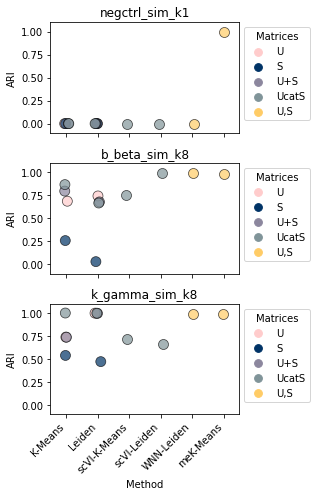

In [487]:
stats_plots(all_sims,stat='ARI',fname='ARI_all_sims.pdf',
            order=['K-Means','Leiden','scVI-K-Means','scVI-Leiden','WNN-Leiden','meK-Means'] ,
            figsize=(4.5,7),palette=palette)

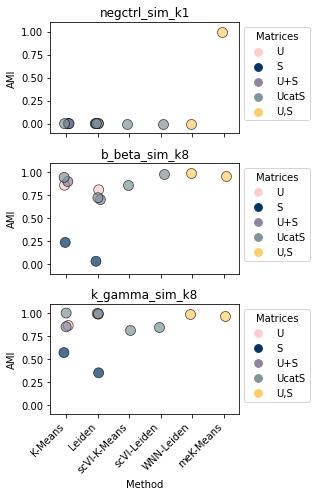

In [488]:
stats_plots(all_sims,stat='AMI',fname='AMI_all_sims.pdf',
            order=['K-Means','Leiden','scVI-K-Means','scVI-Leiden','WNN-Leiden','meK-Means'] ,
            figsize=(4.5,7),palette=palette)

In [703]:
np.unique(all_bench.Hyperparam)

array([-1.  ,  0.75,  1.  ,  1.5 ,  2.  ,  3.  ,  5.  ,  8.  , 10.  ,
       11.  , 15.  , 16.  ])

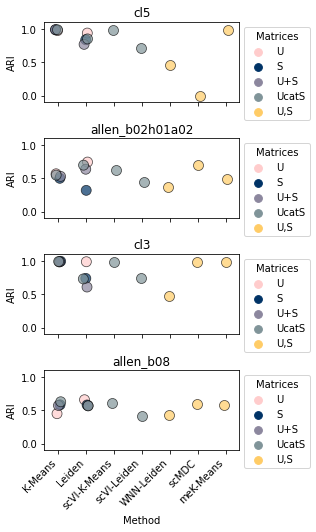

In [704]:
#Use cl3 + allen_bo8 since scMDC worked for both
sub_all_bench = all_bench[~all_bench.HVGs.isin([357,  359,  466,  682]) & ~(all_bench.Method.isin(['meK-Means','scMDC']) & all_bench.Hyperparam.isin([10]) & all_bench.Data.isin(['cl5']))]
stats_plots(sub_all_bench,stat='ARI',hyp_exclude = [-1,0.75,1.5,2.0,8,15,16],
            order=['K-Means','Leiden','scVI-K-Means','scVI-Leiden','WNN-Leiden','scMDC','meK-Means'],
            fname='ARI_all_bench_lgHVGs.pdf',figsize=(4.5,7.5))

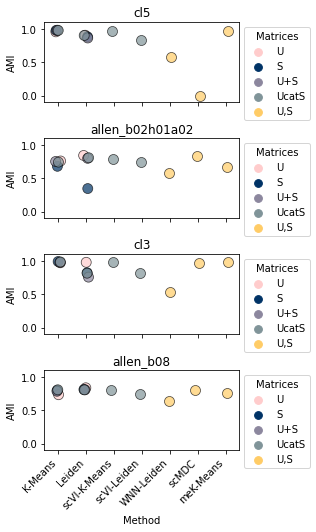

In [706]:
stats_plots(sub_all_bench,stat='AMI',hyp_exclude = [-1,0.75,1.5,2.0,8,15,16],
            order=['K-Means','Leiden','scVI-K-Means','scVI-Leiden','WNN-Leiden','scMDC','meK-Means'],
            fname='AMI_all_bench_lgHVGs.pdf',figsize=(4.5,7.5))

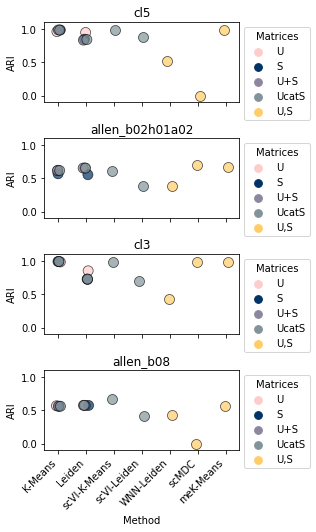

In [490]:
#**PUT ASTERISK BY scMDC, because it didn't run hence the 0..**
sub_all_bench = all_bench[all_bench.HVGs.isin([357,  359,  466,  682]) & ~(all_bench.Method.isin(['meK-Means','scMDC']) & all_bench.Hyperparam.isin([10]) & all_bench.Data.isin(['cl5']))]
stats_plots(sub_all_bench,stat='ARI',hyp_exclude = [-1,0.75,1.5,2.0,8,15,16],
            order=['K-Means','Leiden','scVI-K-Means','scVI-Leiden','WNN-Leiden','scMDC','meK-Means'],
            fname='ARI_all_bench.pdf',figsize=(4.5,7.5))

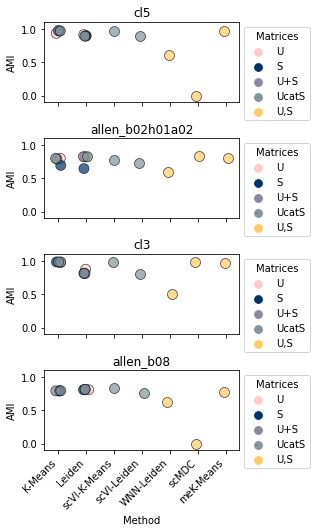

In [491]:
stats_plots(sub_all_bench,stat='AMI',hyp_exclude = [-1,0.75,1.5,2.0,8,15,16],
            order=['K-Means','Leiden','scVI-K-Means','scVI-Leiden','WNN-Leiden','scMDC','meK-Means'],
            fname='AMI_all_bench.pdf',figsize=(4.5,7.5))

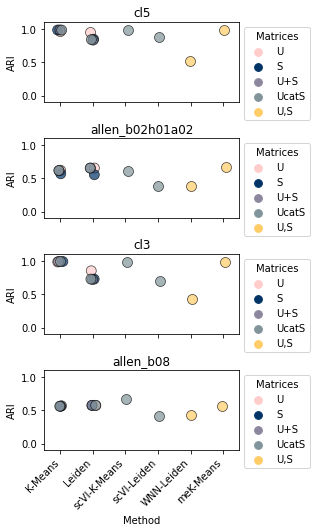

In [492]:
#Plot without scMDC for main Fig
noMDC_bench = sub_all_bench[~sub_all_bench.Method.isin(['scMDC'])]
stats_plots(noMDC_bench,stat='ARI',hyp_exclude = [-1,0.75,1.5,2.0,8,15,16],
            order=['K-Means','Leiden','scVI-K-Means','scVI-Leiden','WNN-Leiden','meK-Means'],
            fname='ARI_noMDC_bench.pdf',figsize=(4.5,7.5))

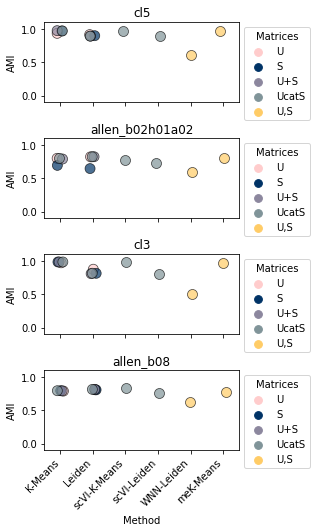

In [493]:
stats_plots(noMDC_bench,stat='AMI',hyp_exclude = [-1,0.75,1.5,2.0,8,15,16],
            order=['K-Means','Leiden','scVI-K-Means','scVI-Leiden','WNN-Leiden','meK-Means'],
            fname='AMI_noMDC_bench.pdf',figsize=(4.5,7.5))

Plot pairwise overlaps of clusterings for Negative Ctrl sim and allen_b08

In [152]:
import itertools

In [494]:
#Get all results frm negctrl to compare
pair_all_sims = all_sims[~all_sims.Hyperparam.isin([0.75,1.5,2.0]) & all_sims.Data.isin(['negctrl_sim_k1'])]
pair_all_sims


,Method,Clustering,Matrices,Hyperparam,HVGs,Data,ARI,AMI,Genes
0,Leiden,0|1|7|8|2|0|2|1|0|3|0|7|0|5|4|2|8|7|9|0|4|5|8|...,U,1.0,1100,negctrl_sim_k1,0.0,1.837018e-16,NaN
1,Leiden,14|12|13|12|2|13|3|11|2|13|3|14|0|0|0|9|10|12|...,S,1.0,1100,negctrl_sim_k1,0.0,2.178137e-16,NaN
2,Leiden,5|9|12|3|2|9|12|0|3|5|0|9|10|1|11|4|10|7|0|4|1...,U+S,1.0,1100,negctrl_sim_k1,0.0,2.179588e-16,NaN
3,Leiden,1|5|1|1|5|1|8|0|5|4|3|3|6|1|0|1|7|1|0|3|7|1|1|...,UcatS,1.0,1100,negctrl_sim_k1,0.0,6.054004e-16,NaN
4,K-Means,4|4|3|2|8|8|0|9|6|5|4|9|6|8|2|4|8|1|3|4|3|8|2|...,U,10.0,1100,negctrl_sim_k1,0.0,2.613066e-16,NaN
5,K-Means,8|5|0|8|8|5|1|4|9|9|2|3|4|1|1|3|3|4|2|2|9|0|9|...,S,10.0,1100,negctrl_sim_k1,0.0,1.389040e-16,NaN
6,K-Means,4|7|2|2|4|9|5|1|6|7|4|9|8|6|2|5|7|2|1|5|9|9|6|...,U+S,10.0,1100,negctrl_sim_k1,0.0,2.272039e-17,NaN
7,K-Means,8|3|7|0|5|5|0|4|0|1|1|7|5|5|9|2|6|0|7|7|7|1|8|...,UcatS,10.0,1100,negctrl_sim_k1,0.0,-1.629062e-16,NaN
26,meK-Means,1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|...,"U,S",10.0,1100,negctrl_sim_k1,1.0,1.000000e+00,1100.0
28,scVI-Leiden,5|6|8|6|4|4|6|0|1|2|0|6|3|2|6|6|9|3|0|6|8|8|5|...,UcatS,1.0,1100,negctrl_sim_k1,0.0,0.000000e+00,NaN


In [495]:
individs = [pair_all_sims.iloc[i]['Method']+'_'+pair_all_sims.iloc[i]['Matrices'] for i in range(len(pair_all_sims))]
pos = range(len(pair_all_sims))
individs

['Leiden_U',
 'Leiden_S',
 'Leiden_U+S',
 'Leiden_UcatS',
 'K-Means_U',
 'K-Means_S',
 'K-Means_U+S',
 'K-Means_UcatS',
 'meK-Means_U,S',
 'scVI-Leiden_UcatS',
 'scVI-K-Means_UcatS',
 'WNN-Leiden_U,S']

In [496]:
pairs = list(itertools.combinations(pos, 2))
aris_pairs_sims = np.zeros([len(pos),len(pos)]) 
for p in pairs:
    out = adjusted_rand_score(pair_all_sims.iloc[p[0]]['Clustering'].split('|'),pair_all_sims.iloc[p[1]]['Clustering'].split('|'))
    aris_pairs_sims[p[0],p[1]] = out
    aris_pairs_sims[p[1],p[0]] = out

aris_pairs_sims = aris_pairs_sims + np.eye(len(pos),len(pos)) 


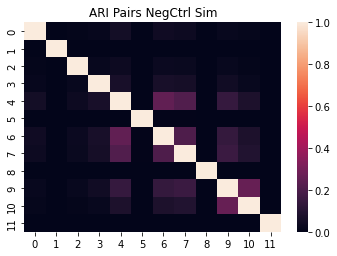

In [497]:
plt.figure(figsize=(5,3.5))
sns.heatmap(aris_pairs_sims, annot = False,vmin=0, vmax=1.0)
plt.tight_layout()
plt.title('ARI Pairs NegCtrl Sim')
plt.savefig('ARI_pairs_negctrl_sim.pdf')

In [731]:
pair_all_sims

,Method,Clustering,Matrices,Hyperparam,HVGs,Data,ARI,AMI,Genes
0,Leiden,0|1|7|8|2|0|2|1|0|3|0|7|0|5|4|2|8|7|9|0|4|5|8|...,U,1.0,1100,negctrl_sim_k1,0.0,1.837018e-16,NaN
1,Leiden,14|12|13|12|2|13|3|11|2|13|3|14|0|0|0|9|10|12|...,S,1.0,1100,negctrl_sim_k1,0.0,2.178137e-16,NaN
2,Leiden,5|9|12|3|2|9|12|0|3|5|0|9|10|1|11|4|10|7|0|4|1...,U+S,1.0,1100,negctrl_sim_k1,0.0,2.179588e-16,NaN
3,Leiden,1|5|1|1|5|1|8|0|5|4|3|3|6|1|0|1|7|1|0|3|7|1|1|...,UcatS,1.0,1100,negctrl_sim_k1,0.0,6.054004e-16,NaN
4,K-Means,4|4|3|2|8|8|0|9|6|5|4|9|6|8|2|4|8|1|3|4|3|8|2|...,U,10.0,1100,negctrl_sim_k1,0.0,2.613066e-16,NaN
5,K-Means,8|5|0|8|8|5|1|4|9|9|2|3|4|1|1|3|3|4|2|2|9|0|9|...,S,10.0,1100,negctrl_sim_k1,0.0,1.389040e-16,NaN
6,K-Means,4|7|2|2|4|9|5|1|6|7|4|9|8|6|2|5|7|2|1|5|9|9|6|...,U+S,10.0,1100,negctrl_sim_k1,0.0,2.272039e-17,NaN
7,K-Means,8|3|7|0|5|5|0|4|0|1|1|7|5|5|9|2|6|0|7|7|7|1|8|...,UcatS,10.0,1100,negctrl_sim_k1,0.0,-1.629062e-16,NaN
26,meK-Means,1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|...,"U,S",10.0,1100,negctrl_sim_k1,1.0,1.000000e+00,1100.0
28,scVI-Leiden,5|6|8|6|4|4|6|0|1|2|0|6|3|2|6|6|9|3|0|6|8|8|5|...,UcatS,1.0,1100,negctrl_sim_k1,0.0,0.000000e+00,NaN


In [498]:
#Get all results frm allen_b08 to compare #DO SINGLE_NUC
pair_all_bench = sub_all_bench[~sub_all_bench.Hyperparam.isin([-1,0.75,1.5,2.0,8,15,16]) & sub_all_bench.Data.isin(['allen_b02h01a02'])]
pair_all_bench


,Method,Clustering,Matrices,Hyperparam,HVGs,Data,ARI,AMI,Genes
44,Leiden,10|1|1|5|2|3|8|1|2|5|3|0|0|2|1|1|2|1|1|1|0|2|8...,U,1.0,359,allen_b02h01a02,0.654273,0.823200,NaN
45,Leiden,6|0|0|4|3|1|5|0|0|4|1|2|1|3|0|0|3|0|0|0|2|3|5|...,S,1.0,359,allen_b02h01a02,0.554039,0.646380,NaN
46,Leiden,11|1|1|5|2|3|8|1|2|5|3|0|0|2|1|1|2|1|1|1|0|2|8...,U+S,1.0,359,allen_b02h01a02,0.654277,0.824783,NaN
47,Leiden,10|1|1|5|2|3|8|1|2|5|3|0|0|2|1|1|2|1|1|1|0|2|8...,UcatS,1.0,359,allen_b02h01a02,0.653671,0.823722,NaN
56,K-Means,9|7|7|2|0|10|3|7|0|2|10|10|10|0|7|7|0|7|7|7|8|...,U,11.0,359,allen_b02h01a02,0.621291,0.800626,NaN
57,K-Means,5|10|10|0|4|6|7|10|6|0|1|2|1|4|10|10|6|10|10|1...,S,11.0,359,allen_b02h01a02,0.568339,0.694427,NaN
58,K-Means,10|3|3|4|0|2|6|3|0|4|2|2|2|9|3|3|9|3|3|3|7|0|6...,U+S,11.0,359,allen_b02h01a02,0.615614,0.790387,NaN
59,K-Means,7|9|9|6|10|8|5|9|10|6|8|2|8|10|9|9|10|9|9|9|2|...,UcatS,11.0,359,allen_b02h01a02,0.617297,0.799530,NaN
162,meK-Means,5|3|3|8|7|1|6|3|7|8|1|0|1|7|3|3|7|3|3|3|0|7|6|...,"U,S",11.0,359,allen_b02h01a02,0.666748,0.802591,359.0
179,scVI-Leiden,15|8|5|9|1|2|12|5|1|9|2|0|2|1|5|8|1|5|5|5|0|1|...,UcatS,1.0,359,allen_b02h01a02,0.389965,0.725709,NaN


In [499]:
individs = [pair_all_bench.iloc[i]['Method']+'_'+pair_all_bench.iloc[i]['Matrices'] for i in range(len(pair_all_bench))]
pos = range(len(pair_all_bench))
individs

['Leiden_U',
 'Leiden_S',
 'Leiden_U+S',
 'Leiden_UcatS',
 'K-Means_U',
 'K-Means_S',
 'K-Means_U+S',
 'K-Means_UcatS',
 'meK-Means_U,S',
 'scVI-Leiden_UcatS',
 'scVI-K-Means_UcatS',
 'WNN-Leiden_U,S',
 'scMDC_U,S']

In [500]:
pairs = list(itertools.combinations(pos, 2))
aris_pairs_bench = np.zeros([len(pos),len(pos)]) 
for p in pairs:
    out = adjusted_rand_score(pair_all_bench.iloc[p[0]]['Clustering'].split('|'),pair_all_bench.iloc[p[1]]['Clustering'].split('|'))
    aris_pairs_bench[p[0],p[1]] = out
    aris_pairs_bench[p[1],p[0]] = out

aris_pairs_bench = aris_pairs_bench + np.eye(len(pos),len(pos)) 


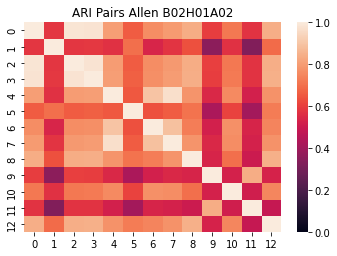

In [501]:
plt.figure(figsize=(5,3.5))
sns.heatmap(aris_pairs_bench, annot = False,vmin=0, vmax=1.0)
plt.tight_layout()
plt.title('ARI Pairs Allen B02H01A02')
plt.savefig('ARI_pairs_allenb02h01a02_bench.pdf')

### **meK-Means Parameter Recapitulation Plots**

Read in results for all simulations and all benchmark datasets with the relevant K

In [502]:
from sklearn.metrics import confusion_matrix

In [503]:
col_all_par = '#4472C4'
col_b = '#1B9AAA'
col_beta = '#9fcbee'
col_gamma ='#3C50B1'
col_expr = '#9299A0'


In [504]:
def check_at_bounds(phys_params,thr=0.01,phys_lb=[-2.0, -1.8, -1.8 ],phys_ub=[4.2, 2.5, 2.5]):
    #Check for genes where parameter fits are close to boundary of grid
    x = np.any(np.logical_or(
        np.array(phys_lb)+thr > phys_params,
        np.array(phys_ub)-thr < phys_params) ,1)
    return x

In [505]:
def plot_conf_mat(true,assign,title='',figsize=(18, 5),fname=None):
    
    #If true labels string, make them ints for plotting  
    if (type(true[0]) != int):
        d = dict(zip(np.unique(true),list(range(len(np.unique(true))))))
        print('Annotations converted to: ',d)
        
        true = [d[t] for t in true]
        true_copy = true.copy()
    else:   
        true_copy = list(true)
    assign_copy = list(assign)
    if np.max(assign) > np.max(true): 
        for a in np.unique(assign):
            if a > np.max(true):
                true_copy += [a]
                assign_copy += [a]
    true_copy = np.array(true_copy)
    assign_copy = np.array(assign_copy)
    
    conmat = confusion_matrix(true_copy, assign_copy)
    val = np.mat(conmat) 
    classnames = list(set(true_copy))
    df_cm = pd.DataFrame(

            val, index=classnames, columns=classnames, 

        )
    
    if np.max(assign) > np.max(true): 
        for a in np.unique(assign):
            if a > np.max(true):
                print(df_cm.shape)
                df_cm.loc[a,a] = df_cm.loc[a,a]-1
         
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    #Plot confusion matrix
    heatmap = sns.heatmap(df_cm, annot=False, fmt=".0f",cmap=sns.color_palette("light:#5A9", as_cmap=True),
                          ax=ax,square=True,linewidths=1, cbar_kws={"shrink": 1})
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',
                                 fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0,
                                fontsize=14)
    
    heatmap.axhline(y=0, color='k',linewidth=2)
    heatmap.axhline(y=val.shape[1], color='k',linewidth=2)
    heatmap.axvline(x=0, color='k',linewidth=2)
    heatmap.axvline(x=val.shape[0], color='k',linewidth=2)

    ax.set_ylabel('True State',fontsize=18)
    ax.set_xlabel('Assigned State',fontsize=18)
    ax.set_title(title)
    
    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)

In [506]:
#Plot correlation of inferred means to observed means
def plot_means(sd,sr,clus=0,title='',figsize=(18,18),fname=None):
    
    clus_ind = [i for i in range(len(sr)) if clus == sr[i].assigns][0]
 
    which_sr = sr[clus_ind]
    mm = which_sr.param_estimates[0,:,:] #genes x params
    
    filt = ~check_at_bounds(mm,thr=0.01) #Filter out genes with bad fits
    
    samp_ub = which_sr.find_sampling_optimum()
    
    mm_u = (mm[:,0]+(samp_ub[0]+sd.gene_log_lengths))-mm[:,1]
    mm_s = (mm[:,0]+samp_ub[1])-mm[:,2]
    #print(mm_s.shape)
    
    
    true_s = sd.layers[1,:,which_sr.filt] #cell x gene
    true_u = sd.layers[0,:,which_sr.filt]
    mean_s = np.mean(true_s,axis=0)
    mean_u = np.mean(true_u,axis=0)
    #print(mean_u.shape)


    
    rho =[]
    p = []   
    
    #Plot param mean correlations
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    g=sns.scatterplot(y=list(mean_u[filt & (mean_u!=0)]),x=list(10**mm_u[filt & (mean_u!=0)]),
                    s=70,edgecolor='black',color='#FFCCCC', alpha=0.8,ax=ax[0])
    ax[0].tick_params(axis='both', which='major', labelsize=14,)
   
    
    rho += [np.corrcoef(list(np.log(mean_u[filt & (mean_u!=0)])),list(np.log(10**mm_u[filt & (mean_u!=0)])))[0,1]]
    p += [scipy.stats.spearmanr(list(mean_u[filt & (mean_u!=0)]),list(10**mm_u[filt & (mean_u!=0)]))[0]]
    
    ax[0].set_xlabel('meK-Means '+r'$\mu_U$',fontsize=14)
    ax[0].set_ylabel('Obs '+r'$\mu_U$',fontsize=14)
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_title(title)

    
    
    g2=sns.scatterplot(y=list(mean_s[filt & (mean_s!=0)]),x=list(10**mm_s[filt & (mean_s!=0)]),
                    s=70,edgecolor='black',color='#003366', alpha=0.6,ax=ax[1])
    ax[1].tick_params(axis='both', which='major', labelsize=14,)
   
    
    rho += [np.corrcoef(list(np.log(mean_s[filt & (mean_s!=0)])),list(np.log(10**mm_s[filt & (mean_s!=0)])))[0,1]]
    p += [scipy.stats.spearmanr(list(mean_s[filt & (mean_s!=0)]),list(10**mm_s[filt & (mean_s!=0)]))[0]]
    
    ax[1].set_xlabel('meK-Means '+r'$\mu_S$',fontsize=14)
    ax[1].set_ylabel('Obs '+r'$\mu_S$',fontsize=14)
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    
    for i, a in enumerate(ax.flat):

       
        bot,top = a.get_ylim()
        l,r = a.get_xlim()

        newl = np.min([bot,l])
        newr = np.max([top,r])

        a.set_xlim((newl,newr))
        a.set_ylim((newl,newr))

        a.text(.05,.7,r'$r$ = {:.2f}'.format(rho[i]),fontsize=14,transform=a.transAxes)
        a.text(.05,.85,r'$\rho$ = {:.2f}'.format(p[i]),fontsize=14,transform=a.transAxes)

        a.plot(a.get_xlim(),a.get_xlim(),'--',color=[116/255,112/255,113/255],linewidth=3,alpha=0.4)

        
    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)

    
    

In [507]:
#Plot parameter distributions vs true params only
def plot_true_params(all_params,sr,true_clus=0,fit_clus=0,figsize=(18,18),fname=None):
    
    b_sim_true = all_params[true_clus,:,:] #kxgenex6 -->0,2,3 b,beta,gamma
    
    clus_ind = [i for i in range(len(sr)) if fit_clus == sr[i].assigns][0]
    which_sr = sr[clus_ind]
    b_sim_mm = which_sr.param_estimates[0,:,:]
    
    filt = ~check_at_bounds(b_sim_mm ,thr=0.01)
    
    rho =[]
    p = []   
    
    

    comps = pd.DataFrame()
    comps['b'] = list(b_sim_true[filt,0])+list(b_sim_mm[filt,0])
    comps['beta'] = list(b_sim_true[filt,2])+list(b_sim_mm[filt,1])
    comps['gamma'] = list(b_sim_true[filt,3])+list(b_sim_mm[filt,2])
    comps['setting'] = ['True']*np.sum(filt) + ['meK-Means']*np.sum(filt)


    #Plot param histograms
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)


    #Plot correlations
    comps_true = comps[comps.setting.isin(['True'])]
    comps_mm = comps[comps.setting.isin(['meK-Means'])]


    #mm v true
    g=sns.scatterplot(x=list(comps_mm['b']),y=list(comps_true['b']),
                    s=50,edgecolor='black',color=col_b, alpha=0.7,ax=ax[0])
    #ax[3,0].text(x=-1, y=2, s=np.corrcoef(list(comps_mm['b']),list(comps_true['b']))[0,1])
    rho += [np.corrcoef(list(comps_mm['b']),list(comps_true['b']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_mm['b']),list(comps_true['b']))[0]]
   

    g1=sns.scatterplot(x=list(comps_mm['beta']),y=list(comps_true['beta']),
                    s=50,edgecolor='black',color=col_beta, alpha=0.7,ax=ax[1],legend=False)
    #ax[3,1].text(x=-1, y=0.5, s=np.corrcoef(list(comps_mm['beta']),list(comps_true['beta']))[0,1])
    rho += [np.corrcoef(list(comps_mm['beta']),list(comps_true['beta']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_mm['beta']),list(comps_true['beta']))[0]]
    


    g2=sns.scatterplot(x=list(comps_mm['gamma']),y=list(comps_true['gamma']),
                    s=50,edgecolor='black',color=col_gamma, alpha=0.7,ax=ax[2],legend=False)
    #ax[3,2].text(x=-1, y=0.5, s=np.corrcoef(list(comps_mm['gamma']),list(comps_true['gamma']))[0,1])
    rho += [np.corrcoef(list(comps_mm['gamma']),list(comps_true['gamma']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_mm['gamma']),list(comps_true['gamma']))[0]]

    
    ax[0].set_xlabel('meK-Means')
    ax[0].set_ylabel('True')
    
    
    for i, a in enumerate(ax.flat):


        bot,top = a.get_ylim()
        l,r = a.get_xlim()

        newl = np.min([bot,l])
        newr = np.max([top,r])

        a.set_xlim((newl,newr))
        a.set_ylim((newl,newr))

        a.text(.05,.7,r'$r$ = {:.2f}'.format(rho[i-3]),fontsize=14,transform=a.transAxes)
        a.text(.05,.8,r'$\rho$ = {:.2f}'.format(p[i-3]),fontsize=14,transform=a.transAxes)

        a.plot(a.get_xlim(),a.get_xlim(),'--',color=[116/255,112/255,113/255],linewidth=3,alpha=0.4)



    
    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)

In [508]:
#Simulation data function
def plot_3d_markers(sr,all_marks,true_clus=0,fit_clus=0,mark_color = '#73a580',figsize=(18,18),fname=None):
    
    marks = all_marks[true_clus*100:(true_clus*100+100)]
    
    clus_ind = [i for i in range(len(sr)) if fit_clus == sr[i].assigns][0]
    which_sr = sr[clus_ind]
    b_sim_mm = which_sr.param_estimates[0,:,:]
    
    sim_mm_cat = []
    for remain in range(len(sr)):
        if sr[remain].assigns != fit_clus:
            sim_mm_cat += [sr[remain].param_estimates[0,:,:]]
    
    sim_mm_cat = np.array(sim_mm_cat)
    #print(np.array(sim_mm_cat)[:,[0,1,2],0].flatten().shape)
    
    allinds = np.array(range(which_sr.n_genes))
    
    filt = ~check_at_bounds(b_sim_mm ,thr=0.01)
    

    toplot = [i for i in marks if i in list(allinds[filt])]
    
    
    all_b_beta = pd.DataFrame()
    all_b_beta['b'] = list(b_sim_mm[toplot,0]) + list(sim_mm_cat[:,toplot,0].flatten())
    all_b_beta['beta'] = list(b_sim_mm[toplot,1]) + list(sim_mm_cat[:,toplot,1].flatten())
    all_b_beta['gamma'] = list(b_sim_mm[toplot,2]) + list(sim_mm_cat[:,toplot,2].flatten())
    all_b_beta['state'] = ['Marked State']*len(toplot) + ['Other States']*len(toplot)*(len(sr)-1)


    palette={'Marked State':mark_color,'Other States':'grey'}
    
    fig = plt.figure(figsize=figsize)
    
    ax = fig.add_subplot(projection='3d')

    all_colors = [palette[i] for i in all_b_beta['state']]
    ax.scatter(all_b_beta['b'], all_b_beta['beta'], all_b_beta['gamma'],
               c=all_colors,s=80,alpha=0.5, edgecolor='black',linewidth=0.5)
    ax.tick_params(axis='both', which='major', labelsize=14,pad=-3)


    ax.grid(None)
    
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)
    

In [509]:
#Simulation data function
def plot_joint_markers(sr,all_marks,true_clus=0,fit_clus=0,mark_color = '#73a580',figsize=(18,18),fname=None):
    #Jointplot of markers
    
    marks = all_marks[true_clus*100:(true_clus*100+100)]
    
    clus_ind = [i for i in range(len(sr)) if fit_clus == sr[i].assigns][0]
    which_sr = sr[clus_ind]
    b_sim_mm = which_sr.param_estimates[0,:,:]
    
    sim_mm_cat = []
    for remain in range(len(sr)):
        if sr[remain].assigns != fit_clus:
            sim_mm_cat += [sr[remain].param_estimates[0,:,:]]
    
    sim_mm_cat = np.array(sim_mm_cat)
    #print(np.array(sim_mm_cat)[:,[0,1,2],0].flatten().shape)
    
    allinds = np.array(range(which_sr.n_genes))
    
    filt = ~check_at_bounds(b_sim_mm ,thr=0.01)
    

    toplot = [i for i in marks if i in list(allinds[filt])]
    
    
    all_b_beta = pd.DataFrame()
    all_b_beta['b'] = list(b_sim_mm[toplot,0]) + list(sim_mm_cat[:,toplot,0].flatten())
    all_b_beta['beta'] = list(b_sim_mm[toplot,1]) + list(sim_mm_cat[:,toplot,1].flatten())
    all_b_beta['gamma'] = list(b_sim_mm[toplot,2]) + list(sim_mm_cat[:,toplot,2].flatten())
    all_b_beta['state'] = ['Marked State']*len(toplot) + ['Other States']*len(toplot)*(len(sr)-1)


    print(all_b_beta.head())

    palette={'Marked State':mark_color,'Other States':'grey'}
    
    plt.figure()
    sns.jointplot(data=all_b_beta.sort_values('state',ascending=False), x="b", y="beta", hue="state",
                  alpha=0.5,s=80,height=3.5,
                  ratio=3,palette=palette,legend=False,marginal_kws={'common_norm':False},
                 edgecolor='black',linewidth=0.5)

    plt.xticks(fontsize=50)
    
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)
    

In [510]:
def print_summary(sr):
    '''
    Get summary of clustering results
    '''
    print('--------------------------')
    print('Model AIC Score: ',sr[0].aic[0])
    for r in sr:
        print('Clus '+str(r.assigns)+' with '+str(np.sum(r.filt))+' cells')
    print('--------------------------')

In [511]:
def get_assigns(sr):
    '''
    Get cell cluster assignments
    '''
    cats = np.array([None]*len(sr[0].filt))
    for r in sr:
        cats[r.filt] = r.assigns
    return cats

In [ ]:
allen_b02h01a02

In [512]:
to_find = ['./fits/meKruns_0306/gg_240216_025_negctrl_sim_k1_K10_1/negctrl_sim_k1/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0306/gg_240216_025_k_gamma_sim_k8_K5_1/k_gamma_sim_k8/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0306/gg_240216_025_b_beta_sim_k8_K10_1/b_beta_sim_k8/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0317/gg_240216_025_cl3_K3_466_1/cl3/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0317/gg_240216_025_cl5_K5_357_1/cl5/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0317/gg_240216_025_allen_b08_K10_682_1/allen_b08/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0317/gg_240216_025_allen_b02h01a02_K11_359_1/allen_b02h01a02/Bursty_Poisson_1x1/*.res']

result_strings = []
for f in to_find:
    result_strings += [glob.glob(f)]

In [513]:
looms = ['/home/tchari/counts/meKMeans_sims/loom/negctrl_sim_k1.loom',
 '/home/tchari/counts/meKMeans_sims/loom/k_gamma_sim_k8.loom',
          '/home/tchari/counts/meKMeans_sims/loom/b_beta_sim_k8.loom',
        '/home/tchari/counts/scMix/cl3/loom/processed_cl3_raw.loom',
        '/home/tchari/counts/scMix/cl5/loom/processed_cl5_raw.loom',
            '/home/tchari/counts/allen_bivi/loom/processed_allen_A08_raw.loom',
        '/home/tchari/counts/allen_bivi/loom/processed_allen_B02H01A02_raw.loom']

len(looms)

7

In [514]:
sr = [] #SearchResults for each dataset
for strings in result_strings:
    sr += [[monod.analysis.load_search_results(i) for i in strings]]

len(sr)

7

In [515]:
#SearchData for each dataset

sd = [monod.analysis.load_search_data(i[:-24]+'raw.sd') for i in to_find]
len(sd)

7

In [516]:
for r in sr:
    print_summary(r)

--------------------------
Model AIC Score:  -1438.503091980141
Clus 1 with 5000 cells
--------------------------
--------------------------
Model AIC Score:  -983.6112261823858
Clus 1 with 1000 cells
Clus 3 with 1500 cells
Clus 4 with 499 cells
Clus 0 with 401 cells
--------------------------
--------------------------
Model AIC Score:  -1523.0633736860614
Clus 2 with 996 cells
Clus 7 with 384 cells
Clus 1 with 1303 cells
Clus 3 with 803 cells
Clus 4 with 203 cells
Clus 5 with 289 cells
Clus 8 with 500 cells
Clus 6 with 522 cells
--------------------------
--------------------------
Model AIC Score:  -752.9140567611436
Clus 2 with 275 cells
Clus 1 with 310 cells
Clus 0 with 317 cells
--------------------------
--------------------------
Model AIC Score:  -407.4033896434299
Clus 2 with 769 cells
Clus 1 with 1257 cells
Clus 3 with 436 cells
Clus 4 with 594 cells
Clus 0 with 862 cells
--------------------------
--------------------------
Model AIC Score:  -1031.1166676054447
Clus 2 with 

Annotations converted to:  {0: 0}
(2, 2)
negctrl_sim_k1_conf_mat.pdf
Annotations converted to:  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


k_gamma_sim_k8_conf_mat.pdf
Annotations converted to:  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
b_beta_sim_k8_conf_mat.pdf


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


Annotations converted to:  {'H1975': 0, 'H2228': 1, 'HCC827': 2}
processed_cl3_raw_conf_mat.pdf
Annotations converted to:  {'A549': 0, 'H1975': 1, 'H2228': 2, 'H838': 3, 'HCC827': 4}


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


processed_cl5_raw_conf_mat.pdf
Annotations converted to:  {'L2/3 IT': 0, 'L5 IT': 1, 'L5/6 NP': 2, 'L6 CT': 3, 'L6 IT': 4, 'L6b': 5, 'Lamp5': 6, 'Pvalb': 7, 'Sst': 8, 'Vip': 9}
processed_allen_A08_raw_conf_mat.pdf
Annotations converted to:  {'L2/3 IT': 0, 'L5 ET': 1, 'L5 IT': 2, 'L5/6 NP': 3, 'L6 CT': 4, 'L6 IT': 5, 'L6b': 6, 'Lamp5': 7, 'Pvalb': 8, 'Sst': 9, 'Vip': 10}


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


processed_allen_B02H01A02_raw_conf_mat.pdf


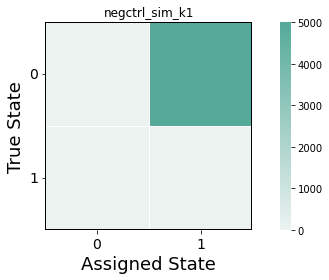

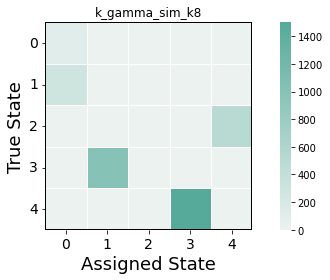

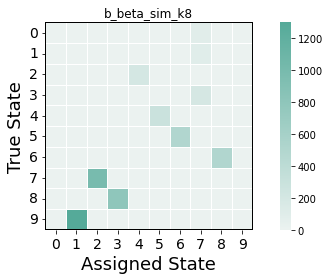

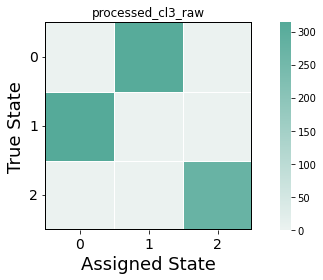

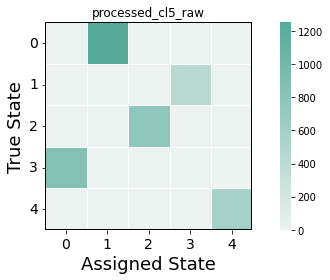

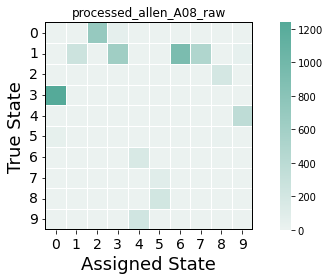

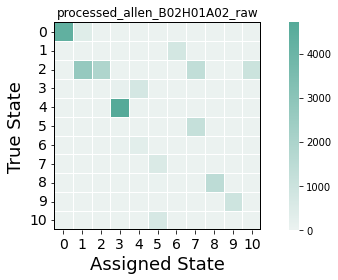

In [517]:
#Confusion matrices for each dataset\
for r,l in zip(sr,looms):
    cats = get_assigns(r)
    ds = lp.connect(l)
    true_labs = ds.ca['subclass_label']
    ds.close()
    fname = l[l.rfind('/')+1:l.rfind('.loom')]+'_conf_mat.pdf'
    plot_conf_mat(true_labs,cats,title=l[l.rfind('/')+1:l.rfind('.loom')],figsize=(8, 4),fname=fname)

    print(fname)

In [518]:
#Compare (3,8) (4,8 in original)
#Compare (3,4) (4,3 in original)

negctrl_sim_k1_clus1_means_corr.pdf
k_gamma_sim_k8_clus4_means_corr.pdf
b_beta_sim_k8_clus5_means_corr.pdf
processed_cl3_raw_clus2_means_corr.pdf
processed_cl5_raw_clus4_means_corr.pdf
processed_allen_A08_raw_clus6_means_corr.pdf
processed_allen_B02H01A02_raw_clus8_means_corr.pdf


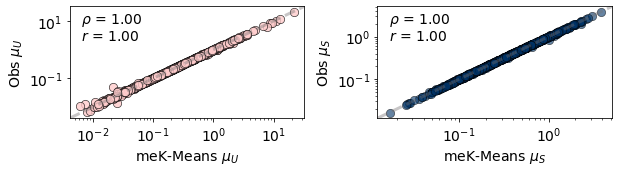

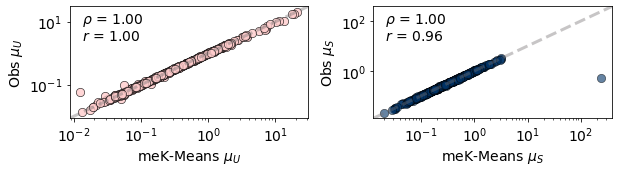

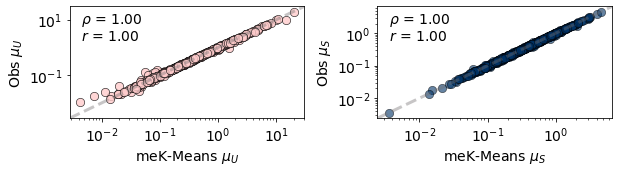

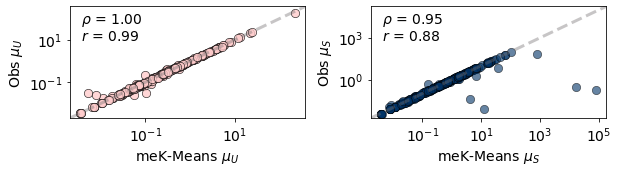

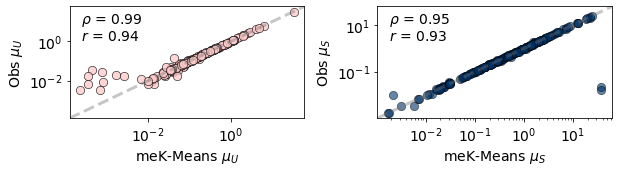

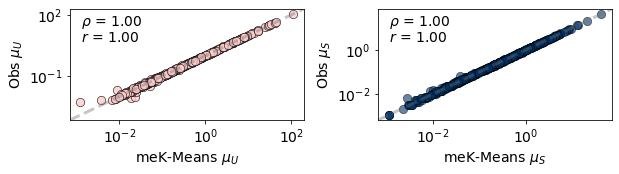

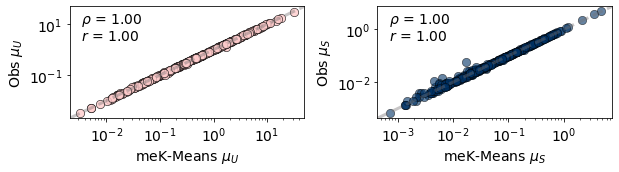

In [710]:
#Mean U,S correlations to parameters for one cluster per dataset
clus_list = [1,4,5,2,4,6,8]

for d,r,clus,l in zip(sd,sr,clus_list,looms):
    fname = l[l.rfind('/')+1:l.rfind('.loom')]+'_clus'+str(clus)+'_means_corr.pdf'
    plot_means(d,r,clus=clus,figsize=(8.7,2.5),fname=fname)
    print(fname)

In [725]:
#Plot param correlations for simulation datasets
out_path = '/home/tchari/counts/meKMeans_sims/loom/'
all_params = np.load(out_path+'all_params.npy',allow_pickle=True)
all_marks= np.load(out_path+'all_marks.npy',allow_pickle=True)

In [726]:
len(all_params)

2

ksim10_trueparams_corr.pdf
ksim5_trueparams_corr.pdf


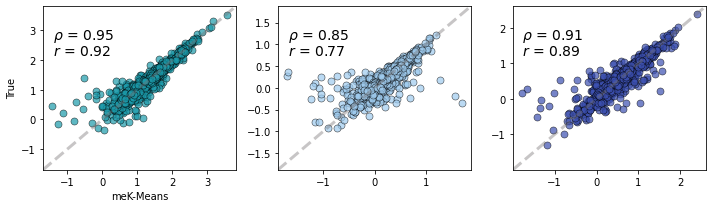

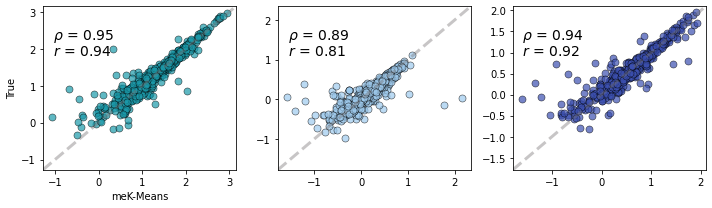

In [727]:
sims_sr = [sr[2],sr[1]]
clus_pairs = [[4,5],[2,4]]
names_tosave = ['ksim10','ksim5']
for r in range(len(sims_sr)):  #Saved in reverese direction in all_params
    plot_true_params(all_params[r],sims_sr[r],
                     true_clus=clus_pairs[r][0],fit_clus=clus_pairs[r][1],
                     figsize=(10,3),fname=names_tosave[r]+'_trueparams_corr.pdf')
    print(names_tosave[r]+'_trueparams_corr.pdf')

In [239]:
#phys_lb = [-3.0, -3, -3 ]  for simulation data

In [728]:
#negctrl

out_path = '/home/tchari/counts/meKMeans_sims/loom/'
all_params_neg = np.load(out_path+'negctrl_params.npy',allow_pickle=True)
#all_marks_neg = np.load(out_path+'all_marks.npy',allow_pickle=True)


negctrl_trueparams_corr.pdf


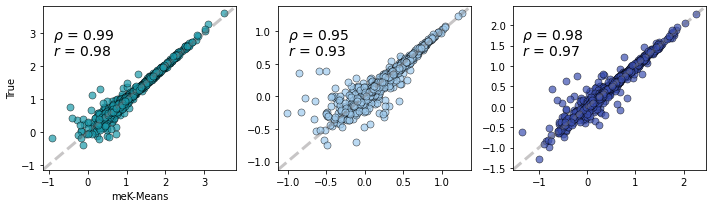

In [729]:
sims_sr = [sr[0]]
clus_pairs = [[0,1]]
names_tosave = ['negctrl']
for r in range(len(sims_sr)):  #Saved in reverese direction in all_params
    plot_true_params([all_params_neg][r],sims_sr[r],
                     true_clus=clus_pairs[r][0],fit_clus=clus_pairs[r][1],
                     figsize=(10,3),fname=names_tosave[r]+'_trueparams_corr.pdf')
    print(names_tosave[r]+'_trueparams_corr.pdf')

**ADD 3D PLOTS FOR SIMULATIONS**

ksim10_3d_params.pdf
          b      beta     gamma         state
0  1.603486 -0.030432 -0.129280  Marked State
1  1.557466  0.275920  0.947644  Marked State
2  1.651339 -0.256251  0.670950  Marked State
3  0.344687 -1.091970 -0.672891  Marked State
4  2.036180 -0.014564  0.705183  Marked State
ksim10_joint_params.pdf
ksim5_3d_params.pdf
          b      beta     gamma         state
0  1.101990 -0.382612  0.289993  Marked State
1  2.046530 -0.154400  1.026247  Marked State
2  1.853560  0.021055  1.496395  Marked State
3  1.467821 -0.046069  0.141599  Marked State
4  2.400429  0.610643  1.451558  Marked State
ksim5_joint_params.pdf


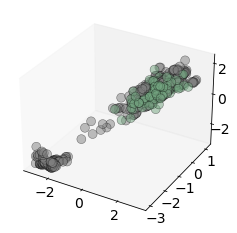

<Figure size 432x288 with 0 Axes>

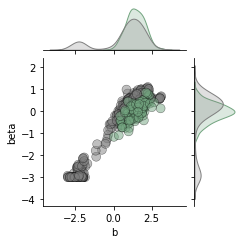

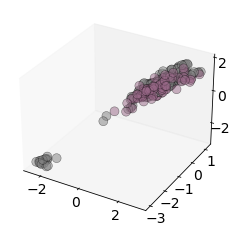

<Figure size 432x288 with 0 Axes>

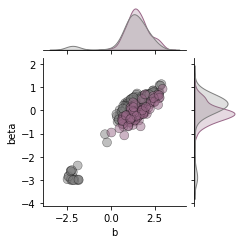

In [475]:
colors = ['#73a580','#996888']
for r in range(len(sims_sr)):
    plot_3d_markers(sims_sr[r],all_marks[r],
                    true_clus=clus_pairs[r][0],fit_clus=clus_pairs[r][1],
                    mark_color = colors[r],figsize=(4,4),fname=names_tosave[r]+'_3d_params.pdf')
    print(names_tosave[r]+'_3d_params.pdf')
    
    plot_joint_markers(sims_sr[r],all_marks[r],
                    true_clus=clus_pairs[r][0],fit_clus=clus_pairs[r][1],
                    mark_color = colors[r],figsize=(1,1),fname=names_tosave[r]+'_joint_params.pdf')
    print(names_tosave[r]+'_joint_params.pdf')
    
    

### **DE-$\theta$ Plots for Benchmarks**

In [554]:
def make_fcs(sr,sd,clus1=0,clus2=1,gf_rej=False,thrpars=2,thrmean=1,outlier_de=True,nuc=False):
    '''
    Utilize different metrics to find fold-changes (FCs) between cluster parameters

    sr: list of SearchResults objects from meK-Means runs
    sd: SearchData object that corresponds to full, input data
    clus1: cluster 1 (to compare FCS of cluster 1/cluster 2 )
    clus2: cluster 2 (to compare FCS of cluster 1/cluster 2 )
    gf_rej: whether to use boolean list of rejected genes from both clusters
    thrpars: FC threshold value (to call DE-theta genes)
    thrmean: Mean S expression threshold value, for genes to consider
    outlier_de: Use iterative outlier calling procedure to assign DE-theta genes (see Monod https://github.com/pachterlab/monod_examples/blob/main/Monod_demo.ipynb)
    nuc: is this nuclear RNA data
    '''

    all_filt_fcs = pd.DataFrame()
    fcs,types,which_pair,highFC,spliceFC,g_names,out_de = ([] for i in range(7))
    
    ind1 = [i for i in range(len(sr)) if clus1 == sr[i].assigns][0]
    ind2 = [i for i in range(len(sr)) if clus2 == sr[i].assigns][0]

    sr1 = sr[ind1]
    sr2 = sr[ind2]
    fc_par = (sr1.param_estimates-sr2.param_estimates)/np.log10(2)  #Get FCs between cluster params
    print('fc_par.shape: ',fc_par.shape)
    if nuc:
        fc_s_par = np.log2(sd.layers[0][:,sr1.filt].mean(1)/sd.layers[0][:,sr2.filt].mean(1))
    else:
        fc_s_par = np.log2(sd.layers[1][:,sr1.filt].mean(1)/sd.layers[1][:,sr2.filt].mean(1)) #Get spliced FCs
        
    print('fc_s_par.shape: ',fc_s_par.shape)

    if outlier_de:
        dr_analysis = monod.analysis.diffexp_pars(sr1,sr2,viz=True,modeltype='id',use_sigma=True)
        par_bool_de = dr_analysis[1].T

    parnames = ('b','beta','gamma')


  #-----is parameter FC significant -----
    if gf_rej is False:
        gf_rej = [True]*sd.n_genes
    else:
        gf_rej = (~sr1.rejected_genes) & (~sr2.rejected_genes)
        
    for n in range(len(parnames)):
        #Boolean for if large param FC and not rejected gene (with minimum expression)
        if nuc:
            gf_highnoise = (np.abs(fc_par[0,:,n])>thrpars)  \
                & ((sd.layers[0][:,sr1.filt].mean(1)>thrmean) | (sd.layers[0][:,sr2.filt].mean(1)>thrmean)) \
                & gf_rej
        else:
            gf_highnoise = (np.abs(fc_par[0,:,n])>thrpars)  \
                & ((sd.layers[1][:,sr1.filt].mean(1)>thrmean) | (sd.layers[1][:,sr2.filt].mean(1)>thrmean)) \
                & gf_rej

        #Boolean for FC (above) but no FC detected at S-level
        gf_highnoise_meanS = gf_highnoise & (np.abs(fc_s_par)<1) & gf_rej

        #Boolean for FC (above)
        gf_onlyhigh = gf_highnoise & gf_rej

        #For dataframe
        fcs += list(fc_par[0,gf_rej,n])
        g_names += list(sr1.gene_names[gf_rej])
        which_pair += [[sr1.assigns,sr2.assigns]]*np.sum(gf_rej)
        highFC += list(gf_onlyhigh[gf_rej])
        spliceFC += list(gf_highnoise_meanS[gf_rej])
        types += [parnames[n]]*np.sum(gf_rej)
        if outlier_de:
            out_de += list(par_bool_de[gf_rej,n])

    if outlier_de:
        all_filt_fcs['deTheta_outlier'] = out_de

    all_filt_fcs['log2FC'] = fcs
    all_filt_fcs['gene'] = g_names
    all_filt_fcs['cluster_pair'] = which_pair
    all_filt_fcs['deTheta_FC'] = highFC
    all_filt_fcs['deTheta_noDeMuS'] = spliceFC
    all_filt_fcs['param'] = types

    return all_filt_fcs


In [555]:
#Get params for each gene, which cluster it marks, and whether it's DE in any param
def get_gene_DE(all_filt_fcs):
    bs = all_filt_fcs[all_filt_fcs.param.isin(['b'])].log2FC
    betas = all_filt_fcs[all_filt_fcs.param.isin(['beta'])].log2FC
    gammas = all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].log2FC
    highFCs = np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].deTheta_FC)
    noSpliceFCs = np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].deTheta_noDeMuS) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].deTheta_noDeMuS) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].deTheta_noDeMuS)

    names = all_filt_fcs[all_filt_fcs.param.isin(['b'])].gene

    dom = []
    for i in range(len(noSpliceFCs)):
        fc_b = list(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].log2FC)[0]
        fc_beta = list(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].iloc[[i]].log2FC)[0]
        fc_gamma = list(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].iloc[[i]].log2FC)[0]

        sig_b = list(np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].deTheta_noDeMuS))[0]
        sig_beta = list(np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].iloc[[i]].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].iloc[[i]].deTheta_noDeMuS))[0]

        sig_gamma = list(np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].iloc[[i]].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].iloc[[i]].deTheta_noDeMuS))[0]


        pairs = list(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].cluster_pair)[0]

# ----- Cell type 'marker' means increase in burst freq,burst,or splicing, or decrease in deg (increased 'stability') ----

        #Increase in burst freq (not outweighted by burst size)
        if (-1*fc_beta > 0 and sig_beta and -1*fc_gamma > 0 and sig_gamma) :
            if (np.abs(fc_b) < np.abs(fc_beta)):
                dom += [pairs[0]]
            elif (fc_b > 0 and sig_b):
                dom += [pairs[0]]
            elif (fc_b < 0 and sig_b):
                dom += [pairs[1]]
            else:
                dom += ['None']
        elif (fc_beta > 0 and sig_beta and fc_gamma > 0 and sig_gamma) :
            if (np.abs(fc_b) < np.abs(fc_beta)):
                dom += [pairs[1]]
            elif (fc_b > 0 and sig_b):
                dom += ['None'] #don't know
            elif (fc_b < 0 and sig_b):
                dom += [pairs[1]]
            else:
                dom += ['None']
        elif sig_b:
            if np.abs(fc_b) > np.abs(fc_beta) and np.abs(fc_b) > np.abs(fc_gamma):
                if fc_b > 0:
                    dom += [pairs[0]]
                else:
                    dom += [pairs[1]]            
            elif np.abs(fc_b) < np.abs(fc_beta):
                if fc_beta > 0:
                    dom += [pairs[0]]
                elif fc_beta < 0:
                    dom += [pairs[1]]
            elif np.abs(fc_b) < np.abs(fc_gamma):
                if fc_gamma < 0:
                    dom += [pairs[0]]
                elif fc_gamma > 0:
                    dom += [pairs[1]]
            else:
                dom += ['None']       
        elif (fc_beta > 0 and sig_beta):
            dom += [pairs[0]]
        elif (fc_gamma > 0 and sig_gamma): #individual FCs
            dom += [pairs[1]]
        elif  (fc_beta < 0 and sig_beta):
            dom += [pairs[1]]
        elif (fc_gamma < 0 and sig_gamma):
            dom += [pairs[0]]
        else:
            dom += ['None']


    return bs,-1*betas,-1*gammas,dom,highFCs,noSpliceFCs,names #-1 for plotting purposes

In [556]:
#Plot FCs of parameters between two clusters

def plot_de(outs,names_plot,mark_plot,xpos,ypos,arrow,assign_colors,figsize=(10,4),betag=False,xlims=[-10,10],fname=None):
    fig,ax = plt.subplots(1,2,figsize=figsize)

    name_inds = [list(outs[6]).index(i) for i in names_plot]

    labs = np.array(outs[3])
    g=sns.scatterplot(x=list(outs[0][labs =='None']),y=list(outs[1][labs=='None']),
                      hue=list(pd.Categorical(outs[3])[labs=='None']),
                      palette=assign_colors,ax=ax[0],style=list(outs[5][labs=='None']),alpha=0.1,s=100,edgecolor='black')

    sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==False)]),
                    y=list(outs[1][(labs!='None') &  (outs[5]==False)]),
                    hue=list(pd.Categorical(outs[3])[(labs!='None') &  (outs[5]==False)]),
                      palette=assign_colors,ax=ax[0],marker='o',alpha=0.6,s=100,edgecolor='black')

    sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==True)]),
                    y=list(outs[1][(labs!='None')  &  (outs[5]==True)]),
                    hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==True)]),
                      palette=assign_colors,ax=ax[0],marker='X',alpha=0.8,s=120,edgecolor='black')

    #Annotate genes
    for n in range(len(names_plot)):
        x=list(outs[0])[name_inds[n]]
        y=list(outs[1])[name_inds[n]]
        h=[pd.Categorical(outs[3])[name_inds[n]]]
        if_x=list(outs[5])[name_inds[n]]
        
        if if_x:
            shape = 'X'
        else:
            shape = 'o'
            
        if arrow[n]:
            #Replot, so annotated points show up on top
            sns.scatterplot(x=x,
                    y=y,
                    hue=h,
                      palette=assign_colors,ax=ax[0],marker=shape,alpha=0.8,s=120,edgecolor='black',
                           legend=False)
            
            ax[0].annotate(names_plot[n], (x, y), fontsize=14,
                           xytext=(x+xpos[n],y+ypos[n]),weight="bold", color=assign_colors[mark_plot[n]],
                       arrowprops = dict(facecolor=assign_colors[mark_plot[n]],  
                                         arrowstyle="-|>",connectionstyle="angle3,angleA=0,angleB=-90",lw=0.4))
        else:
            #Replot, so annotated points show up on top
            sns.scatterplot(x=x,
                    y=y,
                    hue=h,
                      palette=assign_colors,ax=ax[0],marker=shape,alpha=0.8,s=120,edgecolor='black',
                           legend=False)
            
            ax[0].annotate(names_plot[n], (x, y),fontsize=14,
                           xytext=(x+xpos[n], y+ypos[n]),color=assign_colors[mark_plot[n]],weight="bold")

    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

    xl =np.asarray([xlims[0],xlims[1]])
    xlx = [xl[0],xl[1]]
    xly = [xl[0],xl[1]]
    ax[0].set_xlim(xlx)
    ax[0].set_ylim(xly)

    ax[0].plot(xl,-xl,'--',linewidth=2.5,c='crimson',alpha=0.3)

    ax[0].set_xlabel(r'$\log_{2}$FC $b$ ',fontsize=14)
    ax[0].set_ylabel(r'$-\log_{2}$FC $\beta$ ',fontsize=14)
    
    ax[0].tick_params(axis='both', which='major', labelsize=14,)




    if betag == False:
        labs = np.array(outs[3])
        g=sns.scatterplot(x=list(outs[0][labs =='None']),y=list(outs[2][labs=='None']),
                          hue=list(pd.Categorical(outs[3])[labs=='None']),
                          palette=assign_colors,ax=ax[1],style=list(outs[5][labs=='None']),alpha=0.1,s=100,edgecolor='black')

        sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==False)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==False)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==False)]),
                          palette=assign_colors,ax=ax[1],marker='o',alpha=0.6
                        ,s=100,edgecolor='black')

        
        sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==True)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==True)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==True)]),
                          palette=assign_colors,ax=ax[1],marker='X',
                        alpha=0.8,s=120,edgecolor='black')
        #Annotate genes
        for n in range(len(names_plot)):
            x=list(outs[0])[name_inds[n]]
            y=list(outs[2])[name_inds[n]]
            h=[pd.Categorical(outs[3])[name_inds[n]]]
            if_x=list(outs[5])[name_inds[n]]

            if if_x:
                shape = 'X'
            else:
                shape = 'o'

            if arrow[n]:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=100,edgecolor='black',
                               legend=False)
            
                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),weight="bold", color=assign_colors[mark_plot[n]],
                           arrowprops = dict(facecolor=assign_colors[mark_plot[n]],  
                                             arrowstyle="-|>",connectionstyle="angle3,angleA=0,angleB=-90",
                                             lw=0.4,))
            else:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=120,edgecolor='black',
                               legend=False)
            
                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),color=assign_colors[mark_plot[n]],weight="bold")


        sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

        xl =np.asarray([xlims[0],xlims[1]])
        xlx = [xl[0],xl[1]]
        xly = [xl[0],xl[1]]
        ax[1].set_xlim(xlx)
        ax[1].set_ylim(xly)

        ax[1].plot(xl,-xl,'--',linewidth=2.5,c='crimson',alpha=0.3)

        ax[1].set_xlabel(r'$\log_{2}$FC $b$ ',fontsize=14)
        ax[1].set_ylabel(r'$-\log_{2}$FC $\gamma$ ',fontsize=14)
        
        ax[1].tick_params(axis='both', which='major', labelsize=14,)
    else:
        labs = np.array(outs[3])
        g=sns.scatterplot(x=list(outs[1][labs =='None']),y=list(outs[2][labs=='None']),
                          hue=list(pd.Categorical(outs[3])[labs=='None']),
                          palette=assign_colors,ax=ax[1],style=list(outs[5][labs=='None']),alpha=0.1,s=100,edgecolor='black')

        sns.scatterplot(x=list(outs[1][(labs!='None')  &  (outs[5]==False)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==False)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==False)]),
                          palette=assign_colors,ax=ax[1],marker='o',alpha=0.6
                        ,s=100,edgecolor='black')

        
        sns.scatterplot(x=list(outs[1][(labs!='None')  &  (outs[5]==True)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==True)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==True)]),
                          palette=assign_colors,ax=ax[1],marker='X',
                        alpha=0.8,s=120,edgecolor='black')
        #Annotate genes
        for n in range(len(names_plot)):
            x=list(outs[1])[name_inds[n]]
            y=list(outs[2])[name_inds[n]]
            h=[pd.Categorical(outs[3])[name_inds[n]]]
            if_x=list(outs[5])[name_inds[n]]

            if if_x:
                shape = 'X'
            else:
                shape = 'o'

                
            if arrow[n]:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=120,edgecolor='black',
                               legend=False)
                
                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),weight="bold", color=assign_colors[mark_plot[n]],
                           arrowprops = dict(facecolor=assign_colors[mark_plot[n]],  
                                             arrowstyle="-|>",connectionstyle="angle3,angleA=0,angleB=-90",
                                             lw=0.4,))
            else:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=120,edgecolor='black',
                               legend=False)
                
                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),color=assign_colors[mark_plot[n]],weight="bold")



        sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

        xl =np.asarray([xlims[0],xlims[1]])
        xlx = [xl[0],xl[1]]
        xly = [xl[0],xl[1]]
        ax[1].set_xlim(xlx)
        ax[1].set_ylim(xly)

        ax[1].plot(xl,xl,'--',linewidth=2.5,c='crimson',alpha=0.3)

        ax[1].set_xlabel(r'$-\log_{2}$FC $\beta$ ',fontsize=14)
        ax[1].set_ylabel(r'$-\log_{2}$FC $\gamma$ ',fontsize=14)
        
        ax[1].tick_params(axis='both', which='major', labelsize=14,)
        

    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)



Looking at allenB08 Data specifically

Need to:
1. Reject genes with poor fits
2. Plot DE genes between Glut. and GABA population

In [523]:
#For allen B02H01A02 nuc data
#Compare (3,8) (4,8 in original)
#Compare (3,4) (4,3 in original)
#Annotations converted to:  {'L2/3 IT': 0, 'L5 ET': 1, 'L5 IT': 2, 'L5/6 NP': 3, 
# 'L6 CT': 4, 'L6 IT': 5, 'L6b': 6, 'Lamp5': 7, 'Pvalb': 8, 'Sst': 9, 'Vip': 10}
    
    
    
chosen = 6
sr_ofinterest = sr[chosen] 
sd_ofinterest = sd[chosen]


In [649]:
#Set colors for 10 clusters
pal =['#403A5C','#58AD8B','#FFEAB0','#E48F15','#B33254',
        '#7458A6','#F8DBD8','#F2BF94','#5f7a56','#7793c2','#CCCCFF']
assign_colors = dict(zip(range(len(pal)),pal))
assign_colors['None'] = 'lightgrey'

In [525]:
import re

/home/tchari/monod/src/monod/mminference.py:1976: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4154: RuntimeWarning: overflow encountered in exp
  fac1 = a / np.pi * np.exp(gamma)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4154: RuntimeWarning: overflow encountered in double_scalars
  fac1 = a / np.pi * np.exp(gamma)
/home/tchari/monod/src/monod/mminference.py:1976: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4154: RuntimeWarning: overflow encountered in exp
  fac1 = a / np.pi * np.exp(gamma)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4154: RuntimeWarning: ov

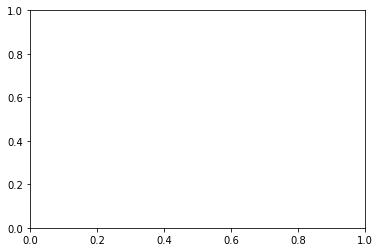

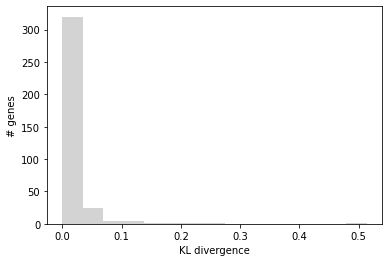

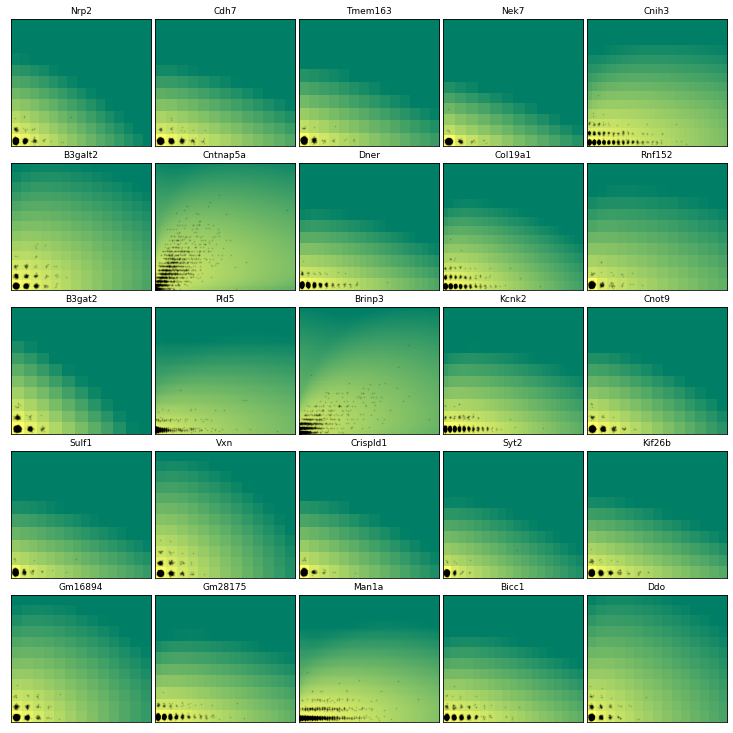

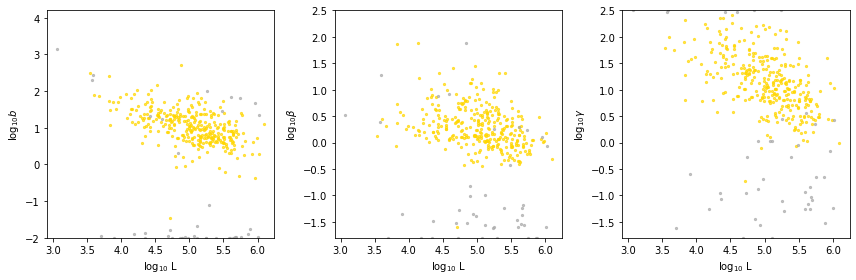

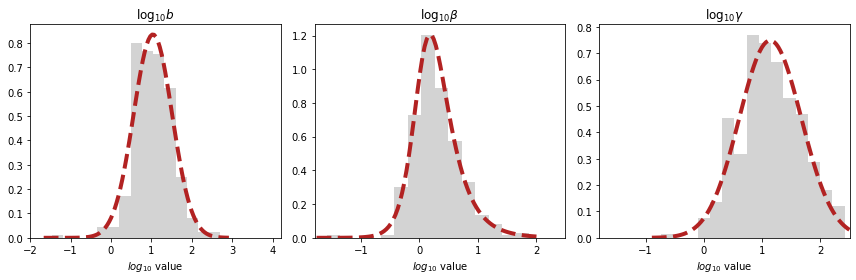

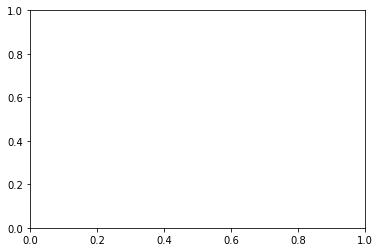

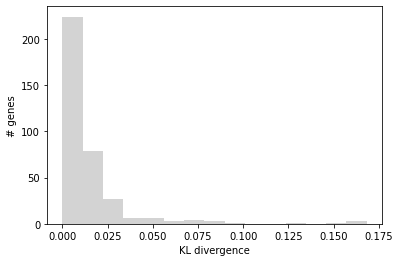

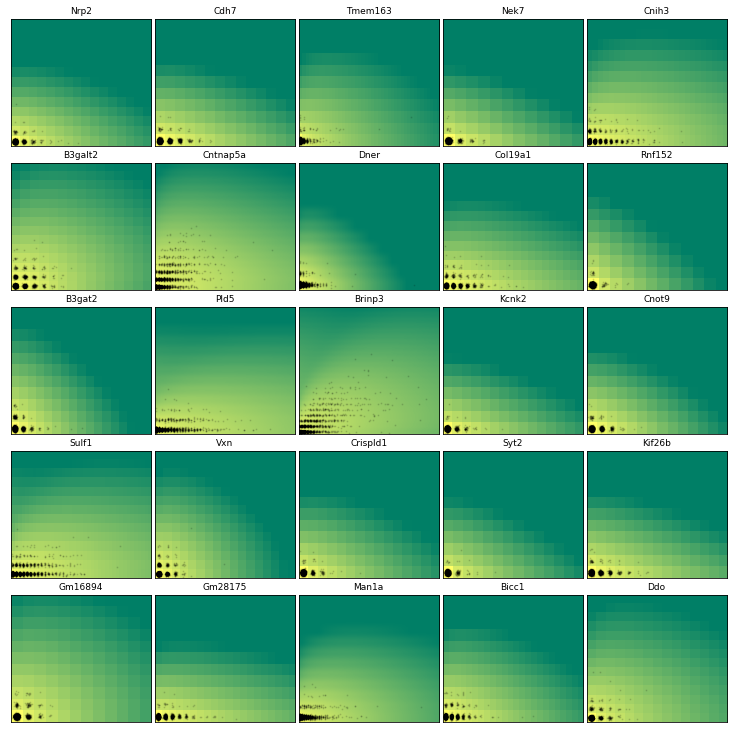

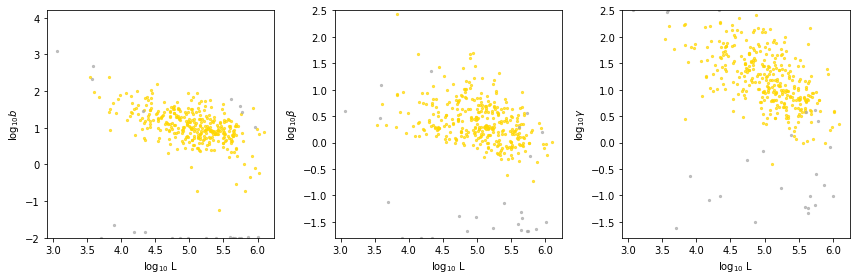

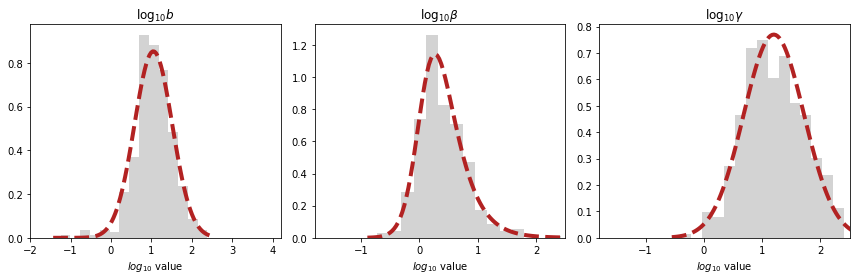

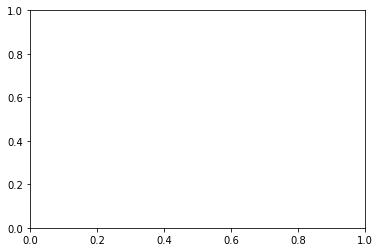

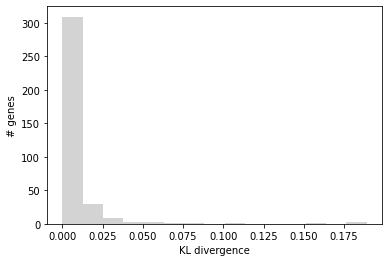

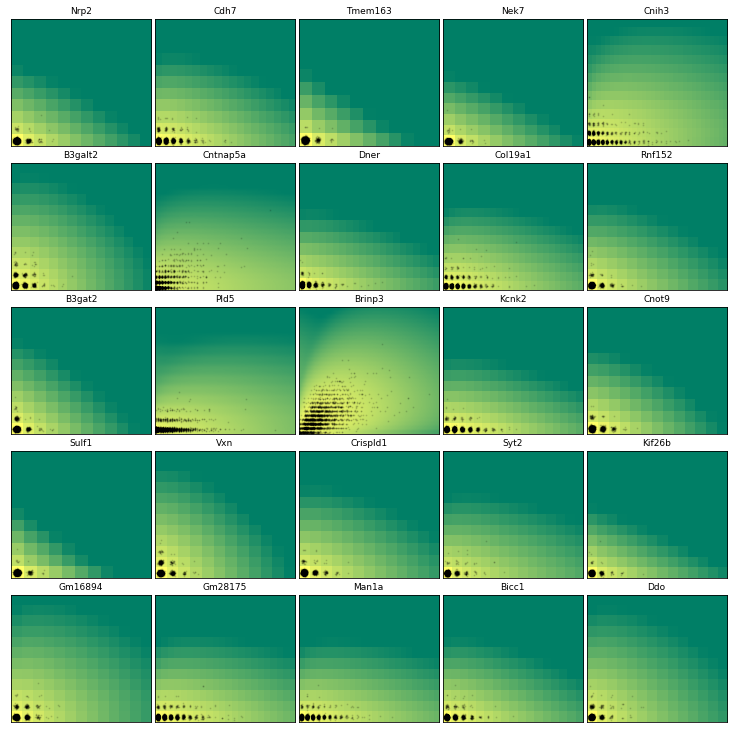

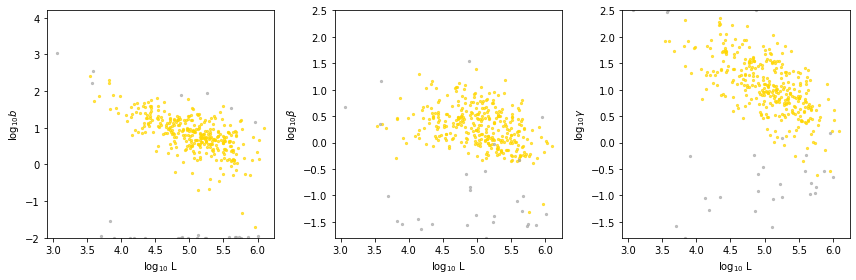

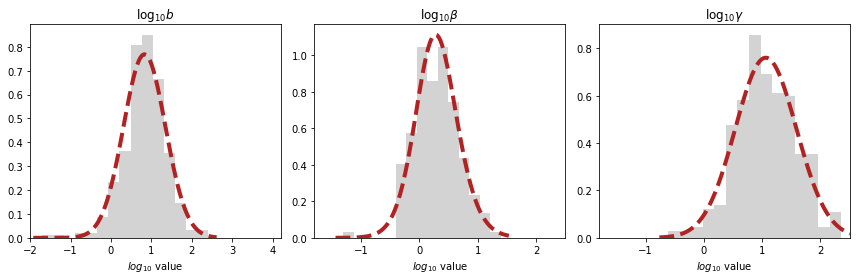

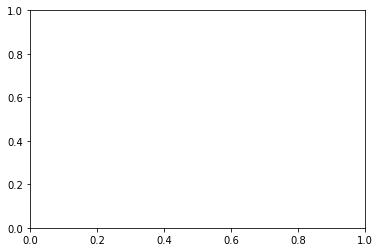

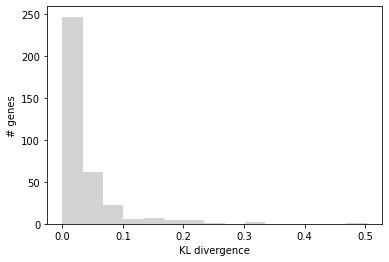

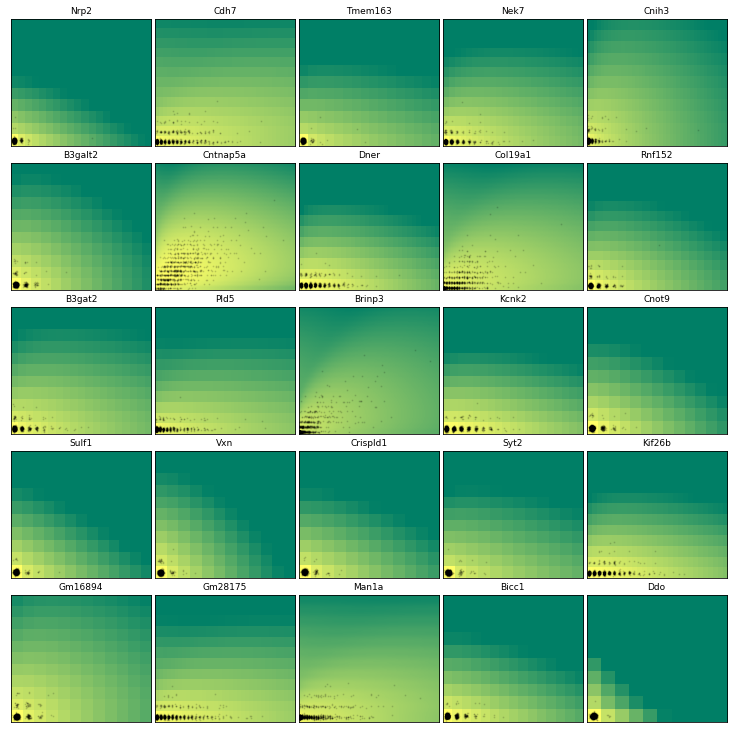

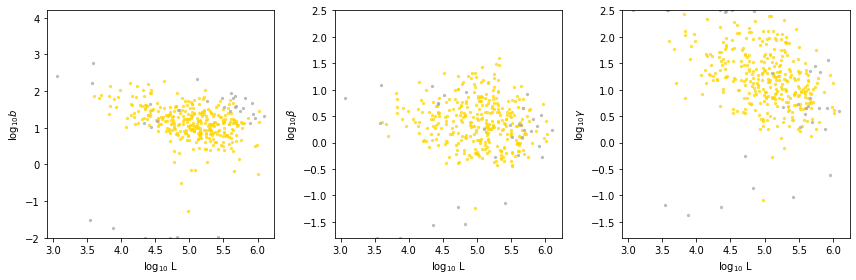

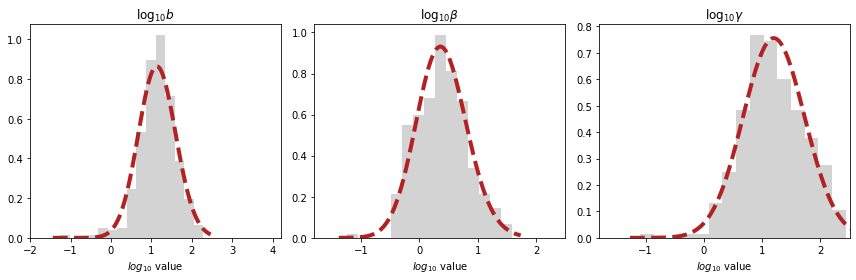

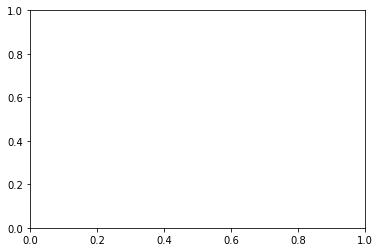

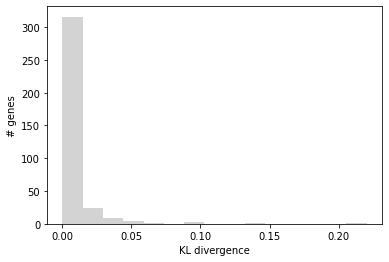

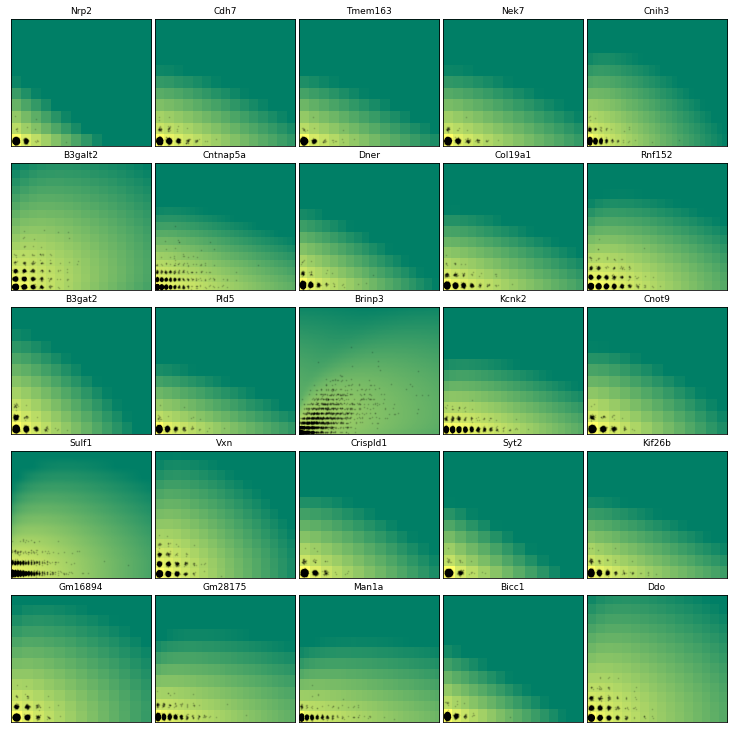

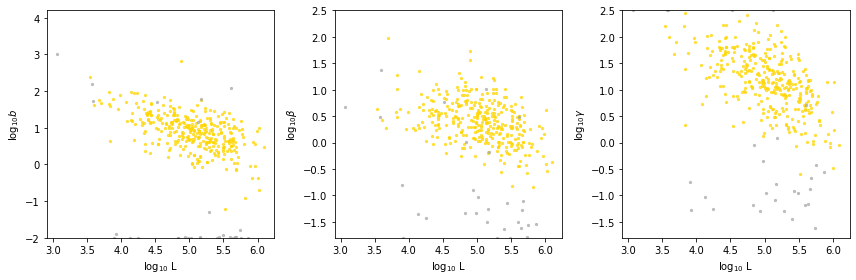

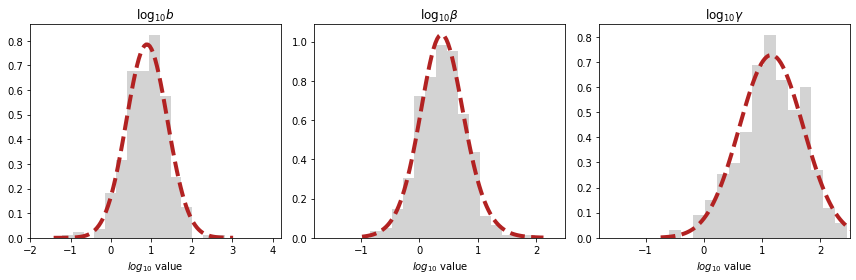

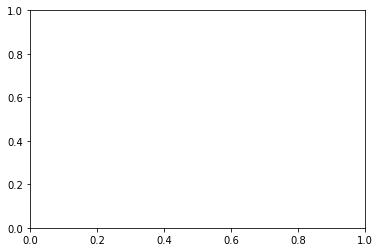

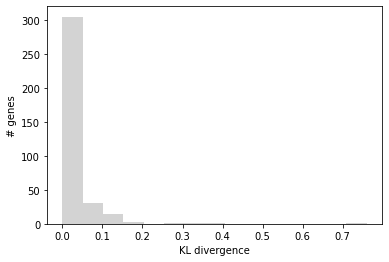

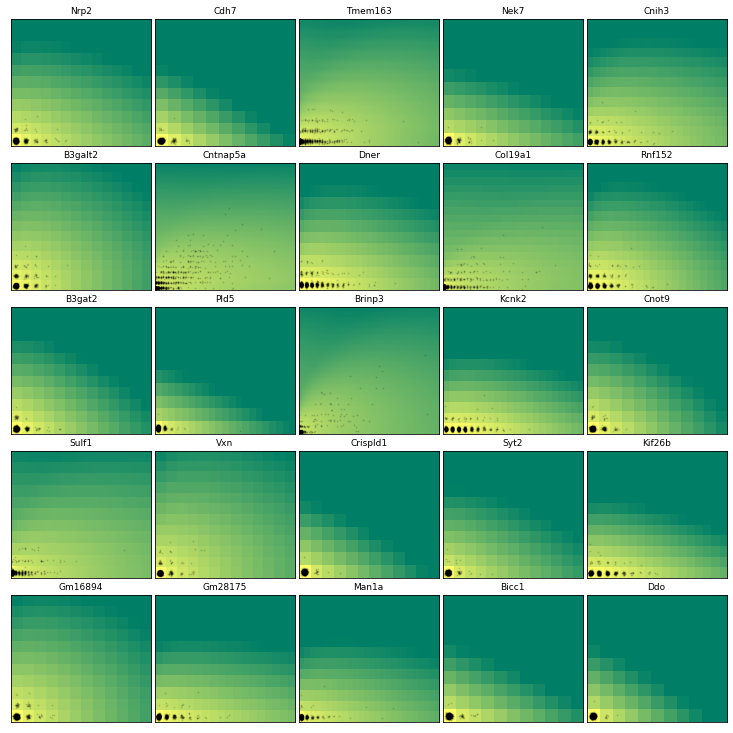

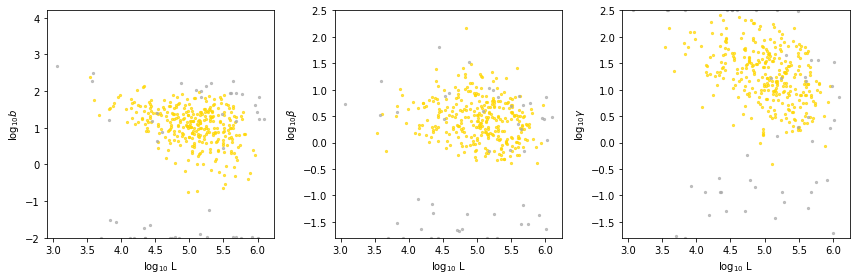

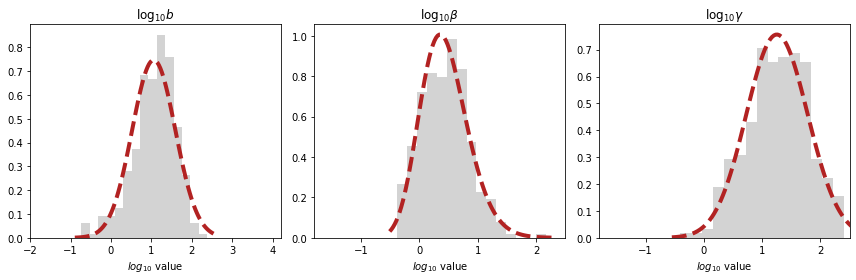

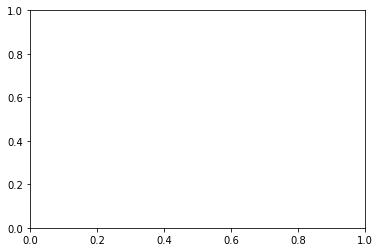

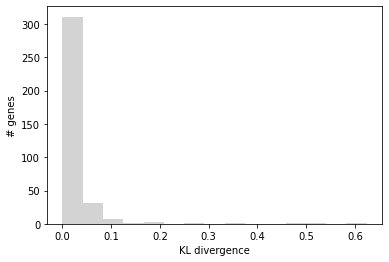

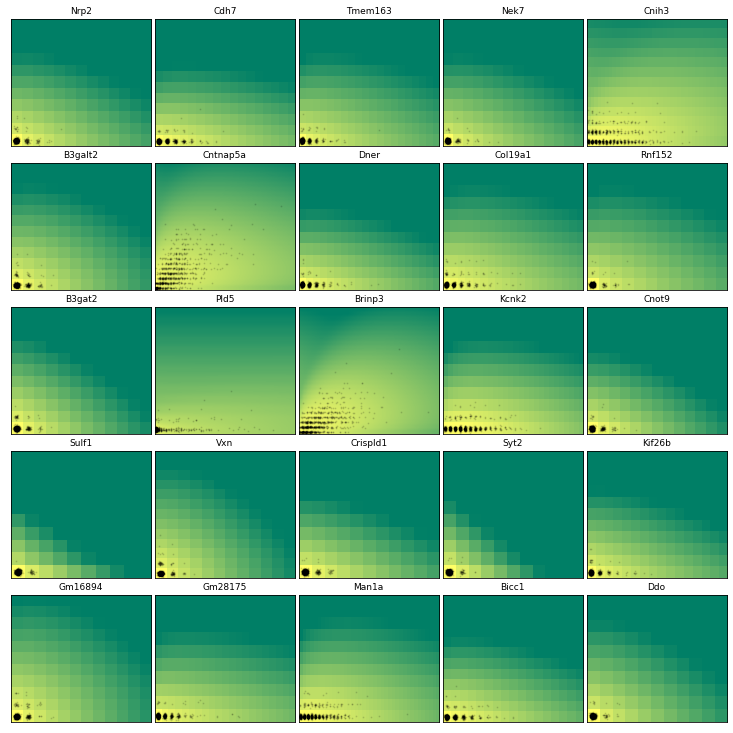

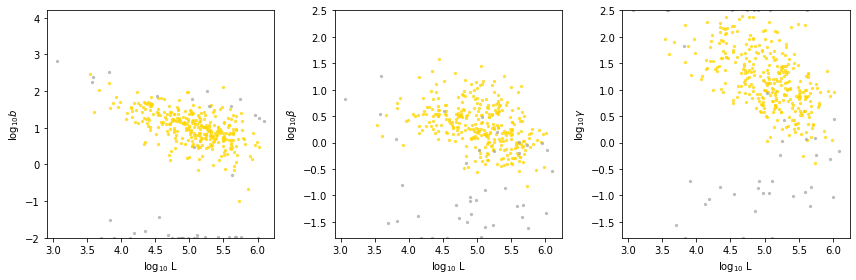

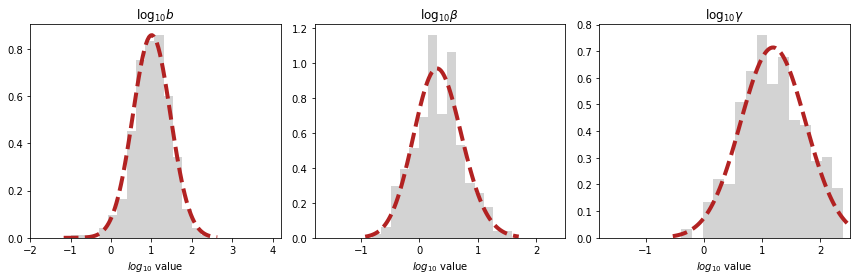

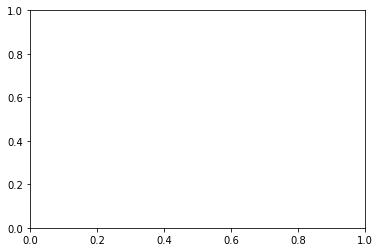

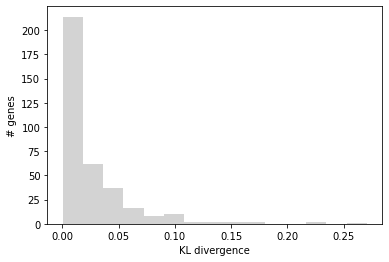

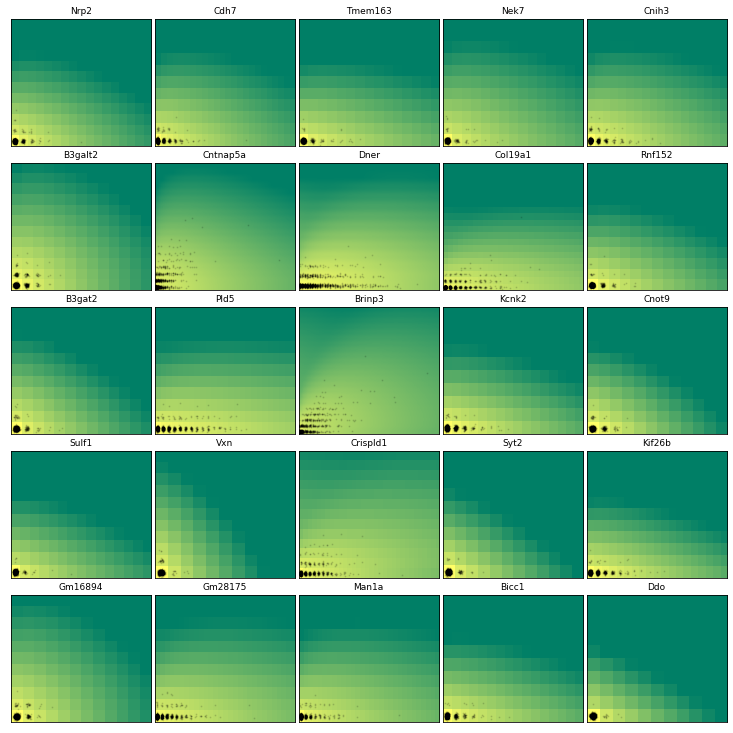

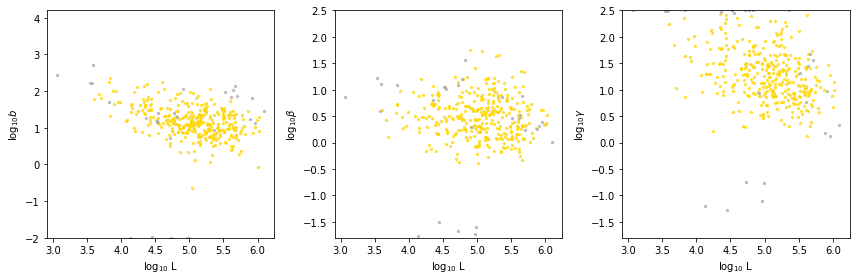

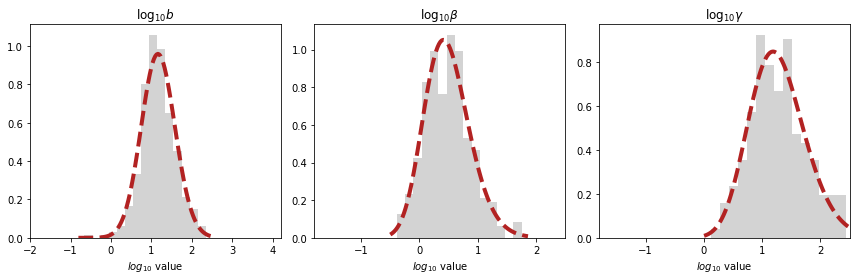

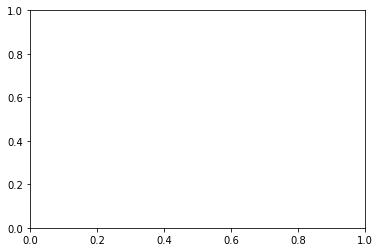

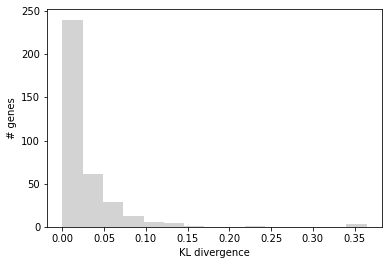

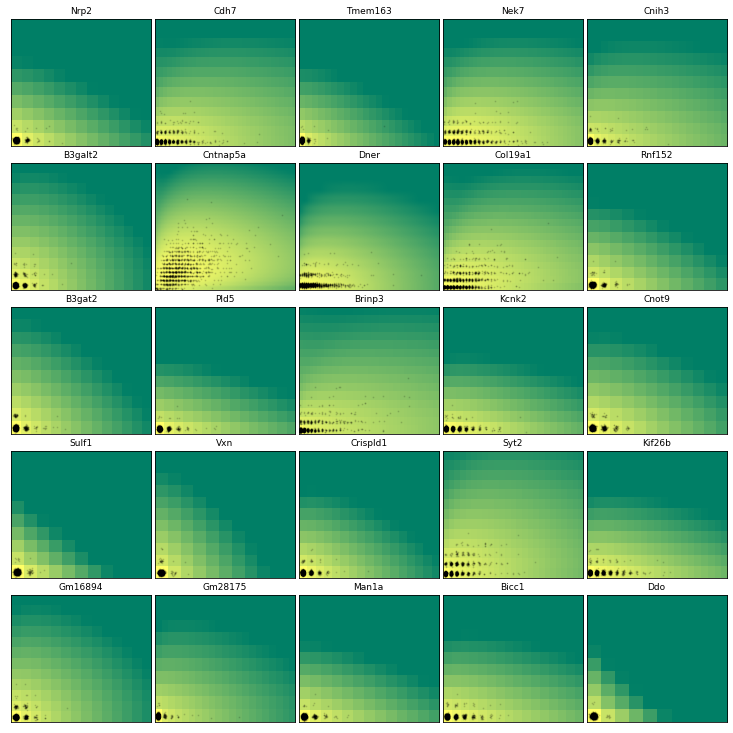

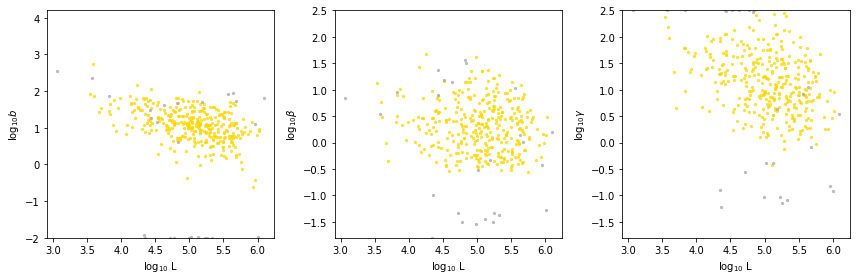

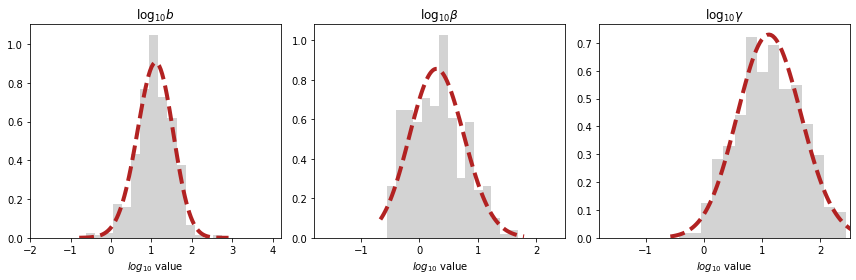

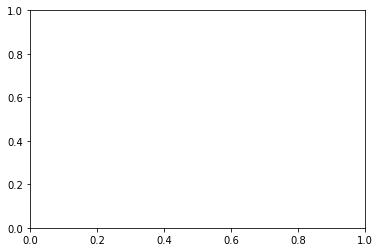

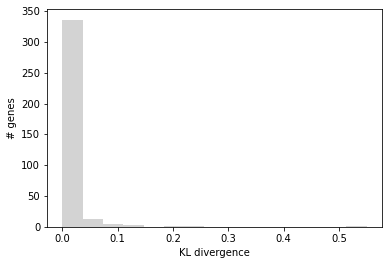

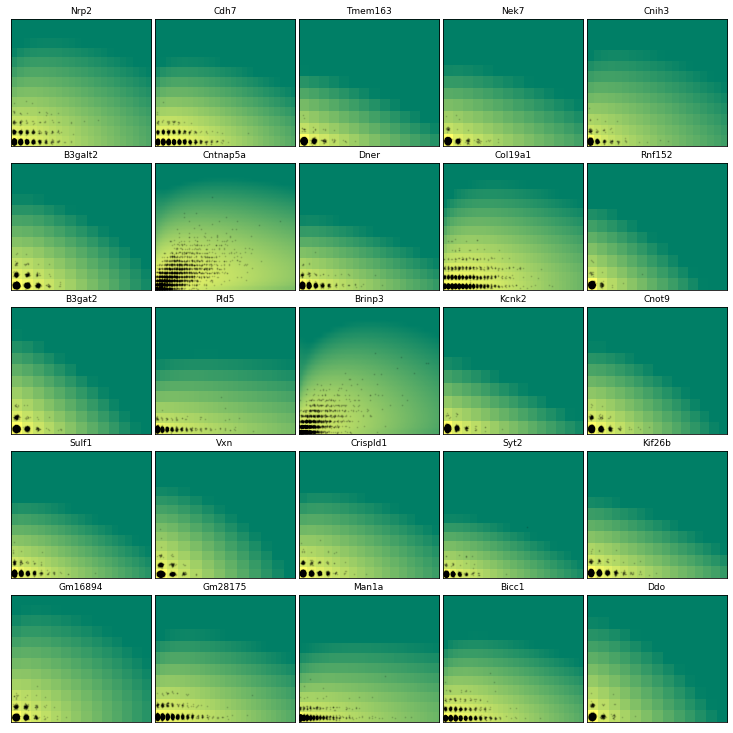

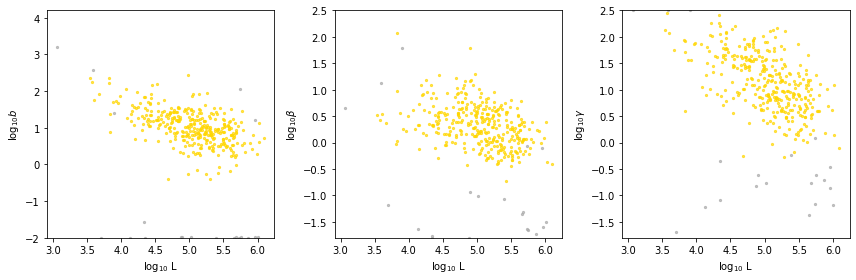

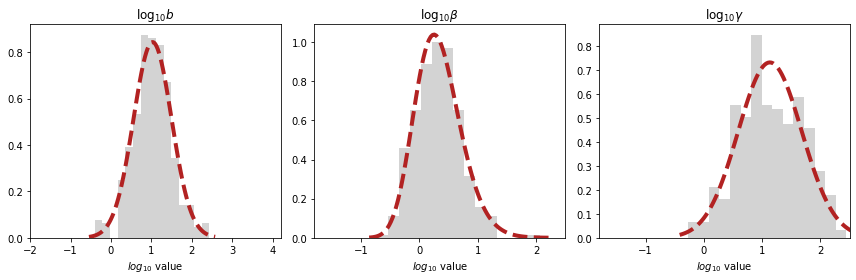

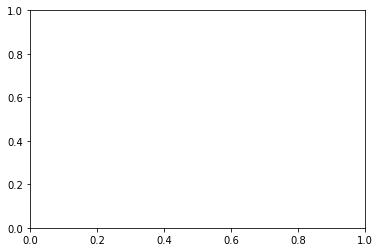

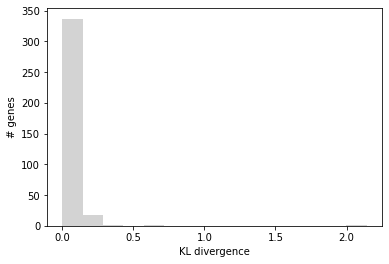

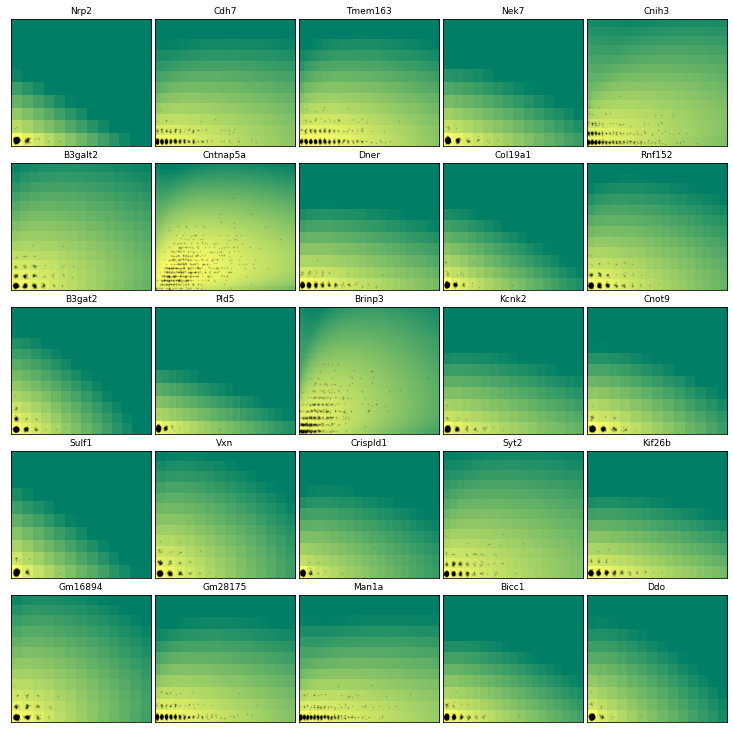

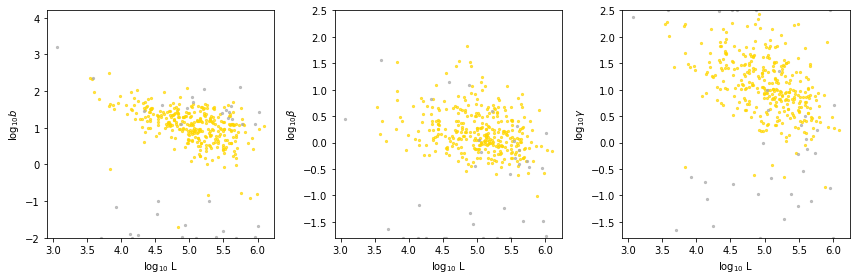

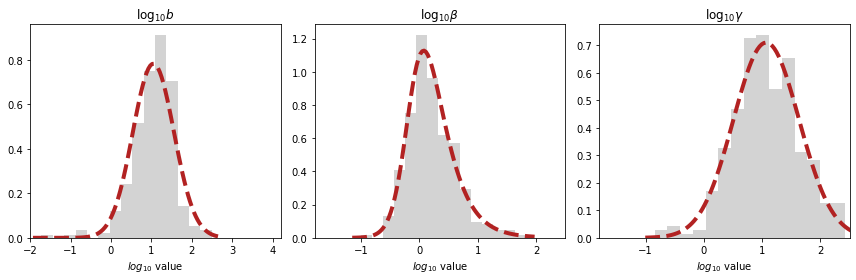

In [526]:
#Run gene rejection statistics
result_strings_ofinterest = result_strings[chosen]
dash_inds = [m.start() for m in re.finditer('/', result_strings_ofinterest[0])]
dir_string = result_strings_ofinterest[0][:dash_inds[3]]

for r in sr_ofinterest:

    fig1,ax1 = plt.subplots(1,1)
    r.find_sampling_optimum() #There is only one set of sampling parameters

    fig1,ax1 = plt.subplots(1,1)
    r.plot_KL(ax1)
    r.plot_gene_distributions(sd_ofinterest,marg='joint')

    _=r.chisquare_testing(sd_ofinterest,threshold=1e-3) #Chi-sq rejection testing
    r.chisq_best_param_correction(sd_ofinterest,Ntries=4,viz=False,threshold=1e-3) 

    r.compute_sigma(sd_ofinterest,num_cores=40) #Sigma, std error calcs
    r.plot_param_L_dep(plot_errorbars=False,plot_fit=True) #Check if burst length-dep exists
    r.plot_param_marg()

    monod.analysis.make_batch_analysis_dir([r],dir_string)
    r.update_on_disk()

In [527]:
result_strings_upd = []
for i in result_strings_ofinterest: #Only did K=7 results
    result_strings_upd += [glob.glob(i[:-4]+'_upd.res')]
    
sr_allen = [] #SearchResults for each dataset
for strings in result_strings_upd:
    sr_allen += [monod.analysis.load_search_results(i) for i in strings]

len(sr_allen)

11

In [682]:
#L5/6 NP, L6 CT, Pvalb markers
#NP markers from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6456269/pdf/nihms-1001532.pdf
np_marks = ['Slc17a7','Fezf2','Rorb','Lypd1','Tmem163','Wls','Ctgf']
ct_marks = ['Slc17a7','Fezf2','Sulf1','Foxp2','Ntsr1','Elavl2', 'Rbfox1']
pvalb_marks = ['Slc32a1','Pvalb','Lhx6','Gad1']

Get param-FCs between clusters of interest

fc_par.shape:  (1, 358, 3)
fc_s_par.shape:  (358,)


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2


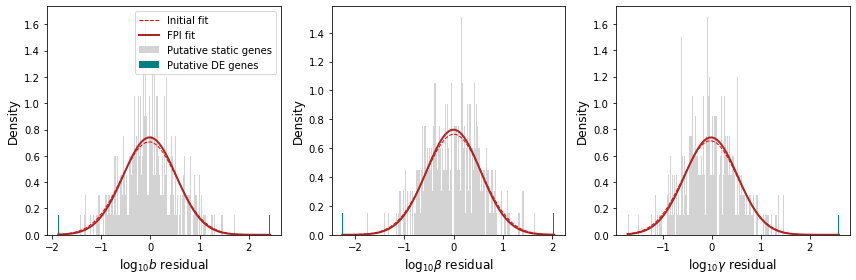

In [688]:
#Compare (3,8) (4,8 in original)
#Compare (3,4) (4,3 in original)

all_filt_fcs = make_fcs(sr_allen,sd_ofinterest,clus1=3,clus2=8,
                gf_rej=True,thrpars=2,thrmean=0.1,outlier_de=True,nuc=True)

In [689]:
all_filt_fcs.head()

,deTheta_outlier,log2FC,gene,cluster_pair,deTheta_FC,deTheta_noDeMuS,param
0,False,-2.371760,Nrp2,"[3, 8]",False,False,b
1,False,-3.038790,Cdh7,"[3, 8]",True,False,b
2,False,-0.960190,Tmem163,"[3, 8]",False,False,b
3,False,-2.364766,Nek7,"[3, 8]",True,False,b
4,False,-1.062436,Cnih3,"[3, 8]",False,False,b


In [690]:
all_filt_fcs[all_filt_fcs['gene'].isin(pvalb_marks+ct_marks)]

,deTheta_outlier,log2FC,gene,cluster_pair,deTheta_FC,deTheta_noDeMuS,param
83,False,-3.334822,Pvalb,"[3, 8]",True,False,b
158,False,0.429594,Slc32a1,"[3, 8]",False,False,b
164,False,-3.815246,Gad1,"[3, 8]",True,False,b
239,False,2.235312,Foxp2,"[3, 8]",True,False,b
392,False,3.649774,Pvalb,"[3, 8]",True,False,beta
467,True,7.754455,Slc32a1,"[3, 8]",True,False,beta
473,False,3.913463,Gad1,"[3, 8]",True,False,beta
548,False,-3.483872,Foxp2,"[3, 8]",True,False,beta
701,False,2.159949,Pvalb,"[3, 8]",True,False,gamma
776,False,4.118826,Slc32a1,"[3, 8]",True,False,gamma


In [691]:
all_filt_fcs[all_filt_fcs['deTheta_noDeMuS'].isin([True])]

,deTheta_outlier,log2FC,gene,cluster_pair,deTheta_FC,deTheta_noDeMuS,param
27,False,-3.038610,Grm1,"[3, 8]",True,True,b
29,False,-2.146882,Tmtc2,"[3, 8]",True,True,b
65,False,-2.024657,Elmo1,"[3, 8]",True,True,b
146,False,-2.249648,Cdh4,"[3, 8]",True,True,b
336,False,-2.579224,Grm1,"[3, 8]",True,True,beta
374,False,-2.361975,Elmo1,"[3, 8]",True,True,beta
400,False,-2.257211,Cdh6,"[3, 8]",True,True,beta
455,False,-2.246313,Cdh4,"[3, 8]",True,True,beta
603,False,-2.040622,Trpc6,"[3, 8]",True,True,beta
645,False,-2.953971,Grm1,"[3, 8]",True,True,gamma


In [692]:
out_marks = get_gene_DE(all_filt_fcs)

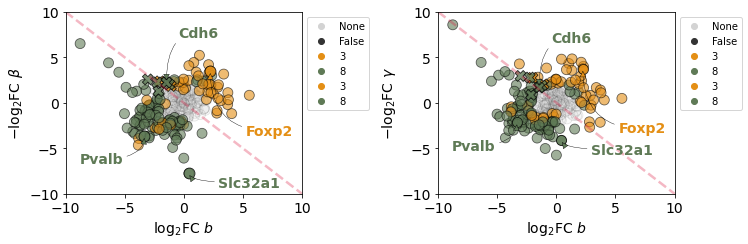

In [693]:
names_plot = ['Pvalb','Slc32a1','Foxp2','Cdh6']
mark_plot = [8,8,3,8]
xpos = [-5.5,2.5,3,1]
ypos = [-3,-1.5,-7,5]
arrow = [True,True,True,True]

plot_de(out_marks,names_plot ,mark_plot,xpos,ypos,arrow,
        assign_colors,figsize=(10.5,3.5),fname='allen_nuc_CTvsPvalb.pdf')

In [651]:
#Differential use of cadherins in diff brain regions
#https://anatomypubs.onlinelibrary.wiley.com/doi/full/10.1002/dvdy.22686 (Cdh6)

Also do two Glut vs each other

fc_par.shape:  (1, 358, 3)
fc_s_par.shape:  (358,)


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


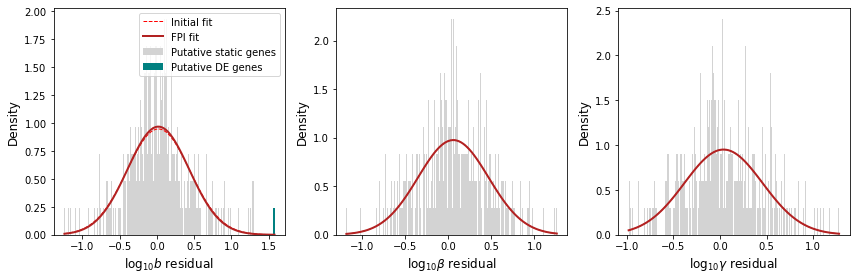

In [694]:
#Compare (3,8) (4,8 in original)
#Compare (3,4) (4,3 in original)

all_filt_fcs = make_fcs(sr_allen,sd_ofinterest,clus1=3,clus2=4,
                gf_rej=True,thrpars=2,thrmean=0.1,outlier_de=True,nuc=True)

out_marks = get_gene_DE(all_filt_fcs)

In [695]:
all_filt_fcs[all_filt_fcs['gene'].isin(np_marks+ct_marks)]

,deTheta_outlier,log2FC,gene,cluster_pair,deTheta_FC,deTheta_noDeMuS,param
2,False,-4.616314,Tmem163,"[3, 4]",True,False,b
12,False,-0.872522,Sulf1,"[3, 4]",False,False,b
138,False,-0.698974,Rorb,"[3, 4]",False,False,b
186,False,-2.197855,Wls,"[3, 4]",True,False,b
230,False,0.491407,Foxp2,"[3, 4]",False,False,b
296,False,1.737028,Tmem163,"[3, 4]",False,False,beta
306,False,-1.743102,Sulf1,"[3, 4]",False,False,beta
432,False,-0.567882,Rorb,"[3, 4]",False,False,beta
480,False,1.601012,Wls,"[3, 4]",False,False,beta
524,False,-2.037052,Foxp2,"[3, 4]",True,False,beta


In [696]:
all_filt_fcs[all_filt_fcs.deTheta_noDeMuS.isin([True])]

,deTheta_outlier,log2FC,gene,cluster_pair,deTheta_FC,deTheta_noDeMuS,param
48,False,-2.953165,Sdk2,"[3, 4]",True,True,b
68,False,-2.046313,Atp6ap1l,"[3, 4]",True,True,b
69,False,-2.882295,Pou6f2,"[3, 4]",True,True,b
100,False,-2.726397,Shisa9,"[3, 4]",True,True,b
135,False,-2.347890,Pip5k1b,"[3, 4]",True,True,b
146,False,-2.996825,Itga8,"[3, 4]",True,True,b
193,False,-3.276408,Igsf21,"[3, 4]",True,True,b
233,False,-2.204549,Antxr1,"[3, 4]",True,True,b
292,False,-2.239756,Pcdh11x,"[3, 4]",True,True,b
342,False,-2.844099,Sdk2,"[3, 4]",True,True,beta


In [697]:
all_filt_fcs[all_filt_fcs.deTheta_noDeMuS.isin([False]) & all_filt_fcs.deTheta_FC.isin([True]) & (all_filt_fcs.log2FC < 0)]

,deTheta_outlier,log2FC,gene,cluster_pair,deTheta_FC,deTheta_noDeMuS,param
0,False,-3.560109,Nrp2,"[3, 4]",True,False,b
2,False,-4.616314,Tmem163,"[3, 4]",True,False,b
6,False,-2.094591,Dner,"[3, 4]",True,False,b
7,False,-4.720619,Col19a1,"[3, 4]",True,False,b
36,False,-4.133283,Moxd1,"[3, 4]",True,False,b
...,...,...,...,...,...,...,...
818,False,-2.029856,Foxp2,"[3, 4]",True,False,gamma
849,False,-3.225094,Plekha2,"[3, 4]",True,False,gamma
862,False,-2.211387,Dscaml1,"[3, 4]",True,False,gamma
867,False,-3.710750,Ephb1,"[3, 4]",True,False,gamma


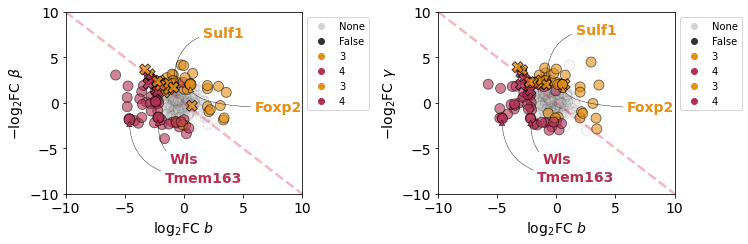

In [698]:
names_plot = ['Foxp2','Sulf1','Tmem163','Wls']
mark_plot = [3,3,4,4]
xpos = [5.5,2.5,3,1]
ypos = [-3,5.5,-7,-5]
arrow = [True,True,True,True]

plot_de(out_marks,names_plot,mark_plot,xpos,ypos,arrow,
        assign_colors,figsize=(10.5,3.5),fname='allen_nuc_CTvsNP.pdf')